In [11]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time


# Load Input Data:

In [12]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p_orig = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p_orig.append(row[1])
print("vot_p_orig:", vot_p_orig)
print()
vot_p = vot_p_orig/np.sum(vot_p_orig)
print("vot_p:\n", vot_p)

vot_p_orig: [0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

vot_p:
 [0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [13]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

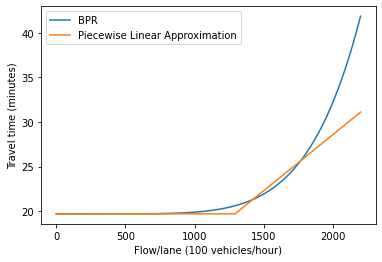

In [14]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [46]:
num_eligible_factor = 1.0

###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v*num_eligible_factor
                               for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.02 (1.2 $/hr), 0.24 (14.399999999999999 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 45.6 $/hr; median: 37.8 $/hr


In [47]:
print("vot_all:", vot_all)
print("num_eligible_factor:", num_eligible_factor)

vot_all: [0.02       0.02       0.02       ... 2.40383333 2.40383333 2.40383333]
num_eligible_factor: 1.0


Text(0, 0.5, '% of population')

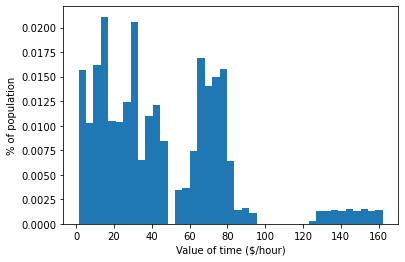

In [48]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

In [49]:
print("len(vots):", len(vots))
print()
print("len(vot_p):", len(vot_p))

print()

print("vots:", vots)
print()
print("vot_p:", vot_p)

len(vots): 18

len(vot_p): 18

vots: [1.2, 2.4, 3.0, 4.81, 6.01, 7.21, 9.62, 10.22, 14.42, 15.02, 20.43, 21.03, 30.05, 42.07, 60.1, 72.12, 84.13, 144.23]

vot_p: [0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Define Social Objectives of Interest:

In [50]:
###### Estimate VoT percentiles for ineligible group ###### 
percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)

12.62
18.55
26.57
30.59
38.12
45.22
64.09
69.2
74.95
80.22
162.22


# Solver 2, Discount:

In [51]:
# Solver 2, Discount:

def OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity, c_2 = bpr_true_capacity, 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope, b_2 = apx_slope):
    """
    Function to solve convex optimization problem given a particular toll and budget value
    """
    
    # Initialize model
    m1 = gp.Model()
    # Add variables to model
#     users_in = m1.addVars(num_ineligible, 3, T, name = 'ineligible_val', lb = 0.0, ub = 2.0)
#     edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = 0.0, ub = num_ineligible * 2.0)
#     users_el = m1.addVars(3, T, name = 'eligible_allocation', lb = 0.0, ub = 2.0)
    # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    
#     # Add variables for piecewise affine approximation
#     eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = 0.0, ub = num_ineligible * 2.0)
    users_in = m1.addVars(num_ineligible, 2, T, name = 'ineligible_val', lb = -10000.0, ub = 10000.0)
    edge_flows = m1.addVars(2, T, name = 'edge_flows', lb = -10000.0, ub = 10000.0)
    users_el = m1.addVars(2, T, name = 'eligible_allocation', lb = -10000.0, ub = 10000.0)
    eps_flows = m1.addVars(2, T, name = 'eps_flows', lb = -10000.0, ub = 10000.0)   

    ## Add constraints to Model 
    
    # Total edge flow, express and general purpose lanes:
    m1.addConstrs((edge_flows[j, t] == sum(users_in[i, j, t] for i in range(num_ineligible)) + \
                  users_el[j, t] for j in range(2) for t in range(T)))
    
    # Non-negativity of flows, and zero flow for "eligible users in ineligible groups":
    m1.addConstrs((users_in[i, j, t]>=0 for i in range(num_ineligible) for j in range(2) for t in range(T)))
    m1.addConstrs((users_el[j, t]>=0 for j in range(2) for t in range(T)))
    
    # Every eligible and ineligible user is assigned to one of three options: \
    # (express paying, express with credit, non-express)
    m1.addConstrs((sum(users_in[i, j, t] for j in range(2)) == 1 for i in range(num_ineligible) for t in range(T)))
    m1.addConstrs((sum(users_el[j, t] for j in range(2)) == num_eligible for t in range(T)))
        
    # Piecewise affine approximation:
    m1.addConstrs((eps_flows[j, t] >= 0 for j in range(2) for t in range(T))) # Must be at least 0
    m1.addConstrs((eps_flows[0, t] >= edge_flows[0, t] - cap_thresh*c_1 for t in range(T))) # Must be at least flow - capacity
    m1.addConstrs((eps_flows[1, t] >= edge_flows[1, t] - cap_thresh*c_2 for t in range(T))) # Must be at least flow - capacity
    
    
    ## To edit below:
    # Set Objective
    m1.setObjective(sum( a*fftt_1*(edge_flows[0, t]) + b_1*(eps_flows[0, t]**2)/2  
                        + a*fftt_2*(edge_flows[1, t]) + b_2*(eps_flows[1, t]**2)/2 
                        + sum( toll*users_in[i,0,t]/vot_ineligible[i,t] for i in range(num_ineligible))
                        + sum( (1 - discount_ratio)*toll*users_el[0,t]/vot_eligible[i,t] for i in range(num_eligible))
        for t in range(T)), GRB.MINIMIZE)
    
    m1.update()
    
    return m1

In [52]:
print("vot_ineligible:", vot_ineligible)
print("\n")
print("vot_eligible:", vot_eligible)

vot_ineligible: [[0.21585865 0.22377924 0.25071884 0.21427864 0.21863694]
 [0.23559858 0.2542718  0.22847527 0.26697925 0.22445655]
 [0.25924703 0.24197597 0.26369475 0.26367383 0.26411293]
 ...
 [2.67647604 2.28188551 2.66216308 2.49209703 2.21634052]
 [2.13565102 2.17838144 2.29926247 2.19585021 2.42774814]
 [2.54085345 2.21568443 2.24821608 2.4964378  2.66516689]]


vot_eligible: [[0.02       0.02       0.02       0.02       0.02      ]
 [0.02       0.02       0.02       0.02       0.02      ]
 [0.02       0.02       0.02       0.02       0.02      ]
 ...
 [0.24033333 0.24033333 0.24033333 0.24033333 0.24033333]
 [0.24033333 0.24033333 0.24033333 0.24033333 0.24033333]
 [0.24033333 0.24033333 0.24033333 0.24033333 0.24033333]]


In [53]:
def _extract_solution_discount(m, num_ineligible = num_ineligible):
    """
    Get solution from optimization model
    """
    users_in = [v.x for v in m.getVars() if v.VarName.find("ineligible_val") != -1]
    users_el = [v.x for v in m.getVars() if v.VarName.find("eligible_allocation") != -1]
    edge_flows = [v.x for v in m.getVars() if v.VarName.find("edge_flows") != -1]
    eps_flows = [v.x for v in m.getVars() if v.VarName.find("eps_flows") != -1]
    
    users_in = np.reshape(users_in, (num_ineligible, 2, T))
    users_el = np.reshape(users_el, (2, T))
    edge_flows = np.reshape(edge_flows, (2, T))
    eps_flows = np.reshape(eps_flows, (2, T))

    solution = {
        "users_in": users_in,
        "users_el": users_el,
        "edge_flows": edge_flows,
        "eps_flows": eps_flows
    }
    return solution

In [54]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Solve Optimization Problem for Discretized Grid:

## Case 2 - Discount:

In [55]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
# print(tau_arr)
# print()
# print(B_arr)
# print()

In [57]:
t_1 = time.time()

demand_multiplier = [25,75]

# For saving data:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data_discount/"

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)

## Toll and budget lists:
tau_arr = 20 * np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = [20]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(0, tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):
    for budget_idx, budget in enumerate(B_arr):
        
#         if budget >= toll * T or budget == 0 or toll == 0:
#             continue
        
        discount_ratio = budget/(toll*T) if (toll != 0 and budget < toll*T) else 1
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print("Discount Ratio:", discount_ratio)
        print()
        
        m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible, 
                    vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
                      fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
                     a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

        m_discount.optimize()
        
        # Extract Solution:
        solution_set = _extract_solution_discount(m_discount)
        
        if toll == tau_arr[0]:
            print()
            print("Edge flows:", solution_set["edge_flows"])
            print()
            
        ### Frank - To modify below:
        # Storing data:
        data_edge_flows = solution_set["edge_flows"].T.reshape(10)
        data_eps_flow = solution_set["eps_flows"].T.reshape(10)
        data_users_el = solution_set["users_el"].T.reshape(10)
        data_users_in = solution_set["users_in"].transpose(0, 2, 1).reshape((num_ineligible, 5*2))
        data = np.vstack((data_edge_flows, data_eps_flow, data_users_el, data_users_in))
        
        file_name = path_directory + "toll_" + to_str(toll) + "_discount_" + to_str(budget) + ".csv"
        df = pd.DataFrame(data, columns = column_names, index = row_names)        
        df.to_csv(file_name)
        
                

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.14s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual  

Presolve time: 0.13s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
  

   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  8.50880702e+05  8.61e-13 2.13e-14  2.92e-10     0s

Barrier solved model in 8 iterations and 0.14 seconds (0.11 work units)
Optimal objective 8.50880702e+05


Edge flows: [[2000. 2000. 2000. 2000. 2000.]
 [6000. 6000. 6000. 6000. 6000.]]


Toll: 0.0
Budget: 45.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4f369e61
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 66410 columns
Presolve time: 0.13s
Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

Presolved: 15 rows, 20 columns, 30 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.38120843e+06 -2.17735323e+07  3.98e+02 8.04e+02  1.33e+06     0s
   1   2.02148139e+06 -7.24030726e+06  2.27e-13 8.04e-04  1.85e+05     0s
   2   1.22672981e+06  3.60901377e+05  6.82e-13 1.35e-05  1.73e+04     0s
   3   8.86371925e+05  7.76264517e+05  1.59e-12 1.34e-11  2.20e+03     0s
   4   8.50996400e+05  8.48068733e+05  5.46e-12 5.68e-14  5.86e+01     0s
   5   8.50880829e+05  8.50866231e+05  1.16e-10 1.42e-14  2.92e-01     0s
   6   8.50880702e+05  8.50880687e+05  2.52e-10 5.68e-14  2.92e-04     0s
   7   8.50880702e+05  8.50880702e+05  1.14e-10 0.00e+00  2.92e-07     0s
   8   8.50880702e+05  

  12   8.52819767e+05  8.52025092e+05  6.24e-06 7.24e-10  1.20e-02     0s
  13   8.52721428e+05  8.52171789e+05  3.88e-06 4.50e-10  8.27e-03     0s
  14   8.52636238e+05  8.52301587e+05  2.30e-06 2.67e-10  5.04e-03     0s
  15   8.52601909e+05  8.52351260e+05  1.71e-06 1.98e-10  3.77e-03     0s
  16   8.52572114e+05  8.52391755e+05  1.22e-06 1.41e-10  2.71e-03     0s
  17   8.52557990e+05  8.52410520e+05  9.92e-07 1.15e-10  2.22e-03     0s
  18   8.52544498e+05  8.52428208e+05  7.82e-07 9.04e-11  1.75e-03     0s
  19   8.52533900e+05  8.52441960e+05  6.15e-07 7.12e-11  1.38e-03     0s
  20   8.52526318e+05  8.52451490e+05  5.02e-07 5.78e-11  1.13e-03     0s
  21   8.52519550e+05  8.52459657e+05  3.99e-07 4.61e-11  9.01e-04     0s
  22   8.52512104e+05  8.52468217e+05  2.92e-07 3.35e-11  6.60e-04     0s
  23   8.52503826e+05  8.52476991e+05  1.44e-07 1.64e-11  4.04e-04     0s
  24   8.52496344e+05  8.52484966e+05  4.54e-08 4.70e-12  1.71e-04     0s
  25   8.52493786e+05  8.52487632e+05 

  23   8.52503826e+05  8.52476991e+05  1.44e-07 1.64e-11  4.04e-04     0s
  24   8.52496344e+05  8.52484966e+05  4.54e-08 4.70e-12  1.71e-04     0s
  25   8.52493786e+05  8.52487632e+05  2.12e-08 2.23e-12  9.26e-05     0s
  26   8.52492215e+05  8.52489255e+05  8.43e-09 9.38e-13  4.45e-05     0s
  27   8.52491497e+05  8.52489992e+05  3.69e-09 4.12e-13  2.27e-05     0s
  28   8.52491250e+05  8.52490250e+05  1.35e-09 5.68e-14  1.51e-05     0s
  29   8.52491000e+05  8.52490503e+05  6.90e-10 5.68e-14  7.48e-06     0s
  30   8.52490860e+05  8.52490643e+05  6.51e-09 5.68e-14  3.26e-06     0s
  31   8.52490777e+05  8.52490727e+05  7.09e-09 8.53e-14  7.55e-07     0s
  32   8.52490752e+05  8.52490751e+05  5.58e-10 5.68e-14  1.79e-08     0s
  33   8.52490752e+05  8.52490752e+05  1.09e-10 5.68e-14  1.85e-11     0s

Barrier solved model in 33 iterations and 0.38 seconds (0.29 work units)
Optimal objective 8.52490752e+05


Toll: 1.0
Budget: 20.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 bui


Barrier solved model in 33 iterations and 0.39 seconds (0.29 work units)
Optimal objective 8.52490752e+05


Toll: 1.0
Budget: 30.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe9676c3f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.65859909e+09 -2.12477527e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.35655804e+06 -8.71028018e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10392513e+06 -3.18657602e+06  1.44e+02 1.68e-02  8.61e+01     0s
   3   9.32595632e+05  2.73925351e+05  2.26e+00 2.63e-04  9.99e+00     0s
   4   8.72501358e+05  8.02137164e+05  1.03e-01 1.20e-05  1.06e+00     0s
   5   8.65680606e+05  8.42422454e+05  3.18e-02 3.69e-06  3.50e-01     0s
   6   8.56399033e+05  8.34962349e+05  1.43e-02 1.66e-06  3.23e-01     0s
   7   8.56533852e+05  8.38717089e+05  9.80e-03 1.14e-06  2.68e-01     0s
   8   8.55777872e+05  8.41330602e+05  1.

   6   8.56399033e+05  8.34962349e+05  1.43e-02 1.66e-06  3.23e-01     0s
   7   8.56533852e+05  8.38717089e+05  9.80e-03 1.14e-06  2.68e-01     0s
   8   8.55777872e+05  8.41330602e+05  1.49e-03 1.73e-07  2.17e-01     0s
   9   8.55029510e+05  8.46744804e+05  4.36e-04 5.06e-08  1.25e-01     0s
  10   8.53368802e+05  8.51072186e+05  2.38e-05 2.76e-09  3.46e-02     0s
  11   8.53007863e+05  8.51684760e+05  1.19e-05 1.38e-09  1.99e-02     0s
  12   8.52819767e+05  8.52025092e+05  6.24e-06 7.24e-10  1.20e-02     0s
  13   8.52721428e+05  8.52171789e+05  3.88e-06 4.50e-10  8.27e-03     0s
  14   8.52636238e+05  8.52301587e+05  2.30e-06 2.67e-10  5.04e-03     0s
  15   8.52601909e+05  8.52351260e+05  1.71e-06 1.98e-10  3.77e-03     0s
  16   8.52572114e+05  8.52391755e+05  1.22e-06 1.41e-10  2.71e-03     0s
  17   8.52557990e+05  8.52410520e+05  9.92e-07 1.15e-10  2.22e-03     0s
  18   8.52544498e+05  8.52428208e+05  7.82e-07 9.04e-11  1.75e-03     0s
  19   8.52533900e+05  8.52441960e+05 

  17   8.52557990e+05  8.52410520e+05  9.92e-07 1.15e-10  2.22e-03     0s
  18   8.52544498e+05  8.52428208e+05  7.82e-07 9.04e-11  1.75e-03     0s
  19   8.52533900e+05  8.52441960e+05  6.15e-07 7.12e-11  1.38e-03     0s
  20   8.52526318e+05  8.52451490e+05  5.02e-07 5.78e-11  1.13e-03     0s
  21   8.52519550e+05  8.52459657e+05  3.99e-07 4.61e-11  9.01e-04     0s
  22   8.52512104e+05  8.52468217e+05  2.92e-07 3.35e-11  6.60e-04     0s
  23   8.52503826e+05  8.52476991e+05  1.44e-07 1.64e-11  4.04e-04     0s
  24   8.52496344e+05  8.52484966e+05  4.54e-08 4.70e-12  1.71e-04     0s
  25   8.52493786e+05  8.52487632e+05  2.12e-08 2.23e-12  9.26e-05     0s
  26   8.52492215e+05  8.52489255e+05  8.43e-09 9.38e-13  4.45e-05     0s
  27   8.52491497e+05  8.52489992e+05  3.69e-09 4.12e-13  2.27e-05     0s
  28   8.52491250e+05  8.52490250e+05  1.35e-09 5.68e-14  1.51e-05     0s
  29   8.52491000e+05  8.52490503e+05  6.90e-10 5.68e-14  7.48e-06     0s
  30   8.52490860e+05  8.52490643e+05 

  28   8.52491250e+05  8.52490250e+05  1.35e-09 5.68e-14  1.51e-05     0s
  29   8.52491000e+05  8.52490503e+05  6.90e-10 5.68e-14  7.48e-06     0s
  30   8.52490860e+05  8.52490643e+05  6.51e-09 5.68e-14  3.26e-06     0s
  31   8.52490777e+05  8.52490727e+05  7.09e-09 8.53e-14  7.55e-07     0s
  32   8.52490752e+05  8.52490751e+05  5.58e-10 5.68e-14  1.79e-08     0s
  33   8.52490752e+05  8.52490752e+05  1.09e-10 5.68e-14  1.85e-11     0s

Barrier solved model in 33 iterations and 0.42 seconds (0.29 work units)
Optimal objective 8.52490752e+05


Toll: 1.0
Budget: 75.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe9676c3f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe9676c3f
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.65859909e+09 -2.12477527e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -3.35655804e+06 -8.71028018e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.10392513e+06 -3.18657602e+0

   0  -6.16177693e+09 -3.99743813e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -2.54658489e+08 -2.68025340e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2   4.90436197e+07 -2.38208260e+09  1.32e+03 9.66e-02  2.80e+02     0s
   3   7.52622816e+06 -1.52469941e+09  8.88e+01 6.50e-03  5.46e+01     0s
   4   2.92106968e+06 -1.16455842e+09  2.37e+01 1.74e-03  3.63e+01     0s
   5   1.14895950e+06 -6.37466327e+08  2.37e-05 1.74e-09  1.88e+01     0s
   6   9.90992211e+05 -4.64914162e+06  1.84e-07 1.35e-11  1.66e-01     0s
   7   9.38114016e+05  3.20233165e+05  2.00e-08 1.46e-12  1.82e-02     0s
   8   8.82209844e+05  7.99118542e+05  1.87e-09 8.88e-16  2.44e-03     0s
   9   8.70979349e+05  8.61302977e+05  7.81e-09 1.14e-13  2.84e-04     0s
  10   8.65302148e+05  8.64458295e+05  2.81e-09 1.14e-13  2.48e-05     0s
  11   8.64806400e+05  8.64681695e+05  4.09e-10 8.88e-16  3.67e-06     0s
  12   8.64749227e+05  8.64721434e+05  6.61e-10 1.14e-13  8.17e-07     0s
  13   8.64738366e+05  8.64729697e+05 

  33   8.53951491e+05  8.53923849e+05  1.23e-06 1.42e-10  4.16e-04     0s
  34   8.53949647e+05  8.53925589e+05  1.07e-06 1.23e-10  3.62e-04     0s
  35   8.53948227e+05  8.53926881e+05  9.54e-07 1.09e-10  3.21e-04     0s
  36   8.53946764e+05  8.53928191e+05  8.29e-07 9.51e-11  2.80e-04     0s
  37   8.53945603e+05  8.53929188e+05  6.78e-07 7.68e-11  2.47e-04     0s
  38   8.53944425e+05  8.53930119e+05  5.33e-07 5.97e-11  2.15e-04     0s
  39   8.53942615e+05  8.53931582e+05  3.24e-07 3.67e-11  1.66e-04     0s
  40   8.53941904e+05  8.53932197e+05  2.60e-07 2.95e-11  1.46e-04     0s
  41   8.53940516e+05  8.53933414e+05  1.58e-07 1.72e-11  1.07e-04     0s
  42   8.53939466e+05  8.53934381e+05  9.76e-08 1.03e-11  7.65e-05     0s
  43   8.53938974e+05  8.53934790e+05  3.99e-08 4.02e-12  6.30e-05     0s
  44   8.53938603e+05  8.53935116e+05  7.14e-09 7.25e-13  5.25e-05     0s
  45   8.53938198e+05  8.53935523e+05  4.69e-09 4.76e-13  4.03e-05     0s
  46   8.53937503e+05  8.53936228e+05 

  10   8.54809281e+05  8.52748286e+05  1.10e-04 1.27e-08  3.10e-02     0s
  11   8.54541427e+05  8.53234586e+05  6.14e-05 7.13e-09  1.97e-02     0s
  12   8.54414545e+05  8.53403292e+05  4.74e-05 5.50e-09  1.52e-02     0s
  13   8.54316593e+05  8.53522940e+05  3.70e-05 4.29e-09  1.19e-02     0s
  14   8.54215766e+05  8.53641029e+05  2.65e-05 3.08e-09  8.65e-03     0s
  15   8.54148312e+05  8.53717229e+05  1.97e-05 2.29e-09  6.49e-03     0s
  16   8.54105070e+05  8.53765109e+05  1.55e-05 1.80e-09  5.12e-03     0s
  17   8.54073901e+05  8.53799169e+05  1.25e-05 1.45e-09  4.13e-03     0s
  18   8.54050668e+05  8.53824099e+05  1.03e-05 1.19e-09  3.41e-03     0s
  19   8.54030365e+05  8.53845492e+05  8.34e-06 9.68e-10  2.78e-03     0s
  20   8.54015632e+05  8.53860560e+05  6.98e-06 8.10e-10  2.33e-03     0s
  21   8.54003805e+05  8.53872573e+05  5.89e-06 6.84e-10  1.97e-03     0s
  22   8.53995791e+05  8.53880702e+05  5.16e-06 5.99e-10  1.73e-03     0s
  23   8.53988367e+05  8.53888126e+05 


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xac1ccca5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.09238351e+09 -2.12206395e+07  6.64e+06 7.71e

  31   8.53955388e+05  8.53920115e+05  1.57e-06 1.82e-10  5.31e-04     0s
  32   8.53953393e+05  8.53922009e+05  1.40e-06 1.61e-10  4.72e-04     0s
  33   8.53951491e+05  8.53923849e+05  1.23e-06 1.42e-10  4.16e-04     0s
  34   8.53949647e+05  8.53925589e+05  1.07e-06 1.23e-10  3.62e-04     0s
  35   8.53948227e+05  8.53926881e+05  9.54e-07 1.09e-10  3.21e-04     0s
  36   8.53946764e+05  8.53928191e+05  8.29e-07 9.51e-11  2.80e-04     0s
  37   8.53945603e+05  8.53929188e+05  6.78e-07 7.68e-11  2.47e-04     0s
  38   8.53944425e+05  8.53930119e+05  5.33e-07 5.97e-11  2.15e-04     0s
  39   8.53942615e+05  8.53931582e+05  3.24e-07 3.67e-11  1.66e-04     0s
  40   8.53941904e+05  8.53932197e+05  2.60e-07 2.95e-11  1.46e-04     0s
  41   8.53940516e+05  8.53933414e+05  1.58e-07 1.72e-11  1.07e-04     0s
  42   8.53939466e+05  8.53934381e+05  9.76e-08 1.03e-11  7.65e-05     0s
  43   8.53938974e+05  8.53934790e+05  3.99e-08 4.02e-12  6.30e-05     0s
  44   8.53938603e+05  8.53935116e+05 

   8   8.60041775e+05  8.42527745e+05  3.21e-03 3.73e-07  2.64e-01     0s
   9   8.58320370e+05  8.47913843e+05  1.33e-03 1.54e-07  1.57e-01     0s
  10   8.54809281e+05  8.52748286e+05  1.10e-04 1.27e-08  3.10e-02     0s
  11   8.54541427e+05  8.53234586e+05  6.14e-05 7.13e-09  1.97e-02     0s
  12   8.54414545e+05  8.53403292e+05  4.74e-05 5.50e-09  1.52e-02     0s
  13   8.54316593e+05  8.53522940e+05  3.70e-05 4.29e-09  1.19e-02     0s
  14   8.54215766e+05  8.53641029e+05  2.65e-05 3.08e-09  8.65e-03     0s
  15   8.54148312e+05  8.53717229e+05  1.97e-05 2.29e-09  6.49e-03     0s
  16   8.54105070e+05  8.53765109e+05  1.55e-05 1.80e-09  5.12e-03     0s
  17   8.54073901e+05  8.53799169e+05  1.25e-05 1.45e-09  4.13e-03     0s
  18   8.54050668e+05  8.53824099e+05  1.03e-05 1.19e-09  3.41e-03     0s
  19   8.54030365e+05  8.53845492e+05  8.34e-06 9.68e-10  2.78e-03     0s
  20   8.54015632e+05  8.53860560e+05  6.98e-06 8.10e-10  2.33e-03     0s
  21   8.54003805e+05  8.53872573e+05 

Optimal objective 8.53936867e+05


Toll: 2.0
Budget: 55.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xac1ccca5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  

  29   8.53959865e+05  8.53915784e+05  1.97e-06 2.27e-10  6.63e-04     0s
  30   8.53957546e+05  8.53918012e+05  1.76e-06 2.04e-10  5.95e-04     0s
  31   8.53955388e+05  8.53920115e+05  1.57e-06 1.82e-10  5.31e-04     0s
  32   8.53953393e+05  8.53922009e+05  1.40e-06 1.61e-10  4.72e-04     0s
  33   8.53951491e+05  8.53923849e+05  1.23e-06 1.42e-10  4.16e-04     0s
  34   8.53949647e+05  8.53925589e+05  1.07e-06 1.23e-10  3.62e-04     0s
  35   8.53948227e+05  8.53926881e+05  9.54e-07 1.09e-10  3.21e-04     0s
  36   8.53946764e+05  8.53928191e+05  8.29e-07 9.51e-11  2.80e-04     0s
  37   8.53945603e+05  8.53929188e+05  6.78e-07 7.68e-11  2.47e-04     0s
  38   8.53944425e+05  8.53930119e+05  5.33e-07 5.97e-11  2.15e-04     0s
  39   8.53942615e+05  8.53931582e+05  3.24e-07 3.67e-11  1.66e-04     0s
  40   8.53941904e+05  8.53932197e+05  2.60e-07 2.95e-11  1.46e-04     0s
  41   8.53940516e+05  8.53933414e+05  1.58e-07 1.72e-11  1.07e-04     0s
  42   8.53939466e+05  8.53934381e+05 

   6   8.59375390e+05  8.39213309e+05  4.56e-03 5.29e-07  3.03e-01     0s
   7   8.59723737e+05  8.40342359e+05  4.20e-03 4.87e-07  2.92e-01     0s
   8   8.60041775e+05  8.42527745e+05  3.21e-03 3.73e-07  2.64e-01     0s
   9   8.58320370e+05  8.47913843e+05  1.33e-03 1.54e-07  1.57e-01     0s
  10   8.54809281e+05  8.52748286e+05  1.10e-04 1.27e-08  3.10e-02     0s
  11   8.54541427e+05  8.53234586e+05  6.14e-05 7.13e-09  1.97e-02     0s
  12   8.54414545e+05  8.53403292e+05  4.74e-05 5.50e-09  1.52e-02     0s
  13   8.54316593e+05  8.53522940e+05  3.70e-05 4.29e-09  1.19e-02     0s
  14   8.54215766e+05  8.53641029e+05  2.65e-05 3.08e-09  8.65e-03     0s
  15   8.54148312e+05  8.53717229e+05  1.97e-05 2.29e-09  6.49e-03     0s
  16   8.54105070e+05  8.53765109e+05  1.55e-05 1.80e-09  5.12e-03     0s
  17   8.54073901e+05  8.53799169e+05  1.25e-05 1.45e-09  4.13e-03     0s
  18   8.54050668e+05  8.53824099e+05  1.03e-05 1.19e-09  3.41e-03     0s
  19   8.54030365e+05  8.53845492e+05 

  50   8.53936867e+05  8.53936867e+05  7.09e-10 5.68e-14  4.93e-11     0s

Barrier solved model in 50 iterations and 0.50 seconds (0.40 work units)
Optimal objective 8.53936867e+05


Toll: 2.0
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xac1ccca5
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-01, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e

  27   8.53966573e+05  8.53909352e+05  2.55e-06 2.96e-10  8.61e-04     0s
  28   8.53962835e+05  8.53913025e+05  2.23e-06 2.57e-10  7.50e-04     0s
  29   8.53959865e+05  8.53915784e+05  1.97e-06 2.27e-10  6.63e-04     0s
  30   8.53957546e+05  8.53918012e+05  1.76e-06 2.04e-10  5.95e-04     0s
  31   8.53955388e+05  8.53920115e+05  1.57e-06 1.82e-10  5.31e-04     0s
  32   8.53953393e+05  8.53922009e+05  1.40e-06 1.61e-10  4.72e-04     0s
  33   8.53951491e+05  8.53923849e+05  1.23e-06 1.42e-10  4.16e-04     0s
  34   8.53949647e+05  8.53925589e+05  1.07e-06 1.23e-10  3.62e-04     0s
  35   8.53948227e+05  8.53926881e+05  9.54e-07 1.09e-10  3.21e-04     0s
  36   8.53946764e+05  8.53928191e+05  8.29e-07 9.51e-11  2.80e-04     0s
  37   8.53945603e+05  8.53929188e+05  6.78e-07 7.68e-11  2.47e-04     0s
  38   8.53944425e+05  8.53930119e+05  5.33e-07 5.97e-11  2.15e-04     0s
  39   8.53942615e+05  8.53931582e+05  3.24e-07 3.67e-11  1.66e-04     0s
  40   8.53941904e+05  8.53932197e+05 

   4   6.88830411e+06 -3.81677237e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.52950757e+06 -3.64386826e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.36934925e+06 -9.07793940e+08  6.25e+00 7.57e-04  1.36e+01     0s
   7   1.05410637e+06 -4.06795562e+07  6.25e-06 7.57e-10  6.13e-01     0s
   8   9.98055318e+05  4.13698001e+05  4.89e-08 5.92e-12  8.59e-03     0s
   9   9.08087545e+05  7.21690622e+05  1.00e-08 1.10e-12  2.74e-03     0s
  10   8.86177590e+05  8.58744287e+05  6.25e-09 1.26e-13  4.03e-04     0s
  11   8.77267690e+05  8.67125467e+05  2.77e-09 3.62e-14  1.49e-04     0s
  12   8.71743639e+05  8.70962206e+05  1.04e-09 1.14e-13  1.15e-05     0s
  13   8.71441793e+05  8.71236864e+05  8.63e-10 8.88e-16  3.01e-06     0s
  14   8.71372255e+05  8.71298512e+05  1.45e-09 5.68e-14  1.08e-06     0s
  15   8.71353064e+05  8.71315784e+05  1.04e-09 5.68e-14  5.48e-07     0s
  16   8.71344639e+05  8.71323276e+05  6.45e-10 5.68e-14  3.14e-07     0s
  17   8.71340190e+05  8.71327224e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.52616792e+09 -2.11935263e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.12075975e+06 -8.65605182e+06  6.29e+03 7.30e-01  1.11e+03     0s
   2   1.13732136e+06 -3.13295556e+06  1.43e+02 1.66e-02  8.59e+01     0s
   3   9.72794370e+05  3.19641547e+05  2.48e+00 2.88e-04  9.92e+00     0s
   4   8.97713043e+05  8.22433262e+05  9.54e-02 1.11e-05  1.13e+00     0s
   5   8.74146461e+05  8.14337620e+05  6.12e-02 7.10e-06  9.01e-01     0s
   6   8.68784307e+05  8.24134756e+05  3.30e-02 3.83e-06  6.73e-01     0s
   7   8.67799761e+05  8.25982806e+05  1.86e-02 2.16e-06  6.30e-01     0s
   8   8.63661595e+05  8.36787254e+05  8.83e-04 1.03e-07  4.04e-01     0s
   9   8.58479988e+05  8.48659143e+05  1.44e-04 1.67e-08  1.48e-01     0s
  10   8.56260181e+05  8.53486323e+05  2.98e-05 3.46e-09  4.17e-02     0s
  11   8.55935261e+05  8.54191524e+05  1.62

   3   9.72794370e+05  3.19641547e+05  2.48e+00 2.88e-04  9.92e+00     0s
   4   8.97713043e+05  8.22433262e+05  9.54e-02 1.11e-05  1.13e+00     0s
   5   8.74146461e+05  8.14337620e+05  6.12e-02 7.10e-06  9.01e-01     0s
   6   8.68784307e+05  8.24134756e+05  3.30e-02 3.83e-06  6.73e-01     0s
   7   8.67799761e+05  8.25982806e+05  1.86e-02 2.16e-06  6.30e-01     0s
   8   8.63661595e+05  8.36787254e+05  8.83e-04 1.03e-07  4.04e-01     0s
   9   8.58479988e+05  8.48659143e+05  1.44e-04 1.67e-08  1.48e-01     0s
  10   8.56260181e+05  8.53486323e+05  2.98e-05 3.46e-09  4.17e-02     0s
  11   8.55935261e+05  8.54191524e+05  1.62e-05 1.88e-09  2.62e-02     0s
  12   8.55766970e+05  8.54456710e+05  1.03e-05 1.20e-09  1.97e-02     0s
  13   8.55610616e+05  8.54705493e+05  5.86e-06 6.80e-10  1.36e-02     0s
  14   8.55469054e+05  8.54918004e+05  3.48e-06 4.03e-10  8.29e-03     0s
  15   8.55411972e+05  8.54996488e+05  2.39e-06 2.77e-10  6.25e-03     0s
  16   8.55356466e+05  8.55072043e+05 

   8   8.63661595e+05  8.36787254e+05  8.83e-04 1.03e-07  4.04e-01     0s
   9   8.58479988e+05  8.48659143e+05  1.44e-04 1.67e-08  1.48e-01     0s
  10   8.56260181e+05  8.53486323e+05  2.98e-05 3.46e-09  4.17e-02     0s
  11   8.55935261e+05  8.54191524e+05  1.62e-05 1.88e-09  2.62e-02     0s
  12   8.55766970e+05  8.54456710e+05  1.03e-05 1.20e-09  1.97e-02     0s
  13   8.55610616e+05  8.54705493e+05  5.86e-06 6.80e-10  1.36e-02     0s
  14   8.55469054e+05  8.54918004e+05  3.48e-06 4.03e-10  8.29e-03     0s
  15   8.55411972e+05  8.54996488e+05  2.39e-06 2.77e-10  6.25e-03     0s
  16   8.55356466e+05  8.55072043e+05  1.61e-06 1.86e-10  4.28e-03     0s
  17   8.55330859e+05  8.55105755e+05  1.27e-06 1.47e-10  3.39e-03     0s
  18   8.55311767e+05  8.55130094e+05  1.02e-06 1.18e-10  2.73e-03     0s
  19   8.55295321e+05  8.55150747e+05  8.15e-07 9.37e-11  2.18e-03     0s
  20   8.55282511e+05  8.55166558e+05  6.52e-07 7.50e-11  1.74e-03     0s
  21   8.55272062e+05  8.55179353e+05 

  13   8.55610616e+05  8.54705493e+05  5.86e-06 6.80e-10  1.36e-02     0s
  14   8.55469054e+05  8.54918004e+05  3.48e-06 4.03e-10  8.29e-03     0s
  15   8.55411972e+05  8.54996488e+05  2.39e-06 2.77e-10  6.25e-03     0s
  16   8.55356466e+05  8.55072043e+05  1.61e-06 1.86e-10  4.28e-03     0s
  17   8.55330859e+05  8.55105755e+05  1.27e-06 1.47e-10  3.39e-03     0s
  18   8.55311767e+05  8.55130094e+05  1.02e-06 1.18e-10  2.73e-03     0s
  19   8.55295321e+05  8.55150747e+05  8.15e-07 9.37e-11  2.18e-03     0s
  20   8.55282511e+05  8.55166558e+05  6.52e-07 7.50e-11  1.74e-03     0s
  21   8.55272062e+05  8.55179353e+05  5.21e-07 5.98e-11  1.40e-03     0s
  22   8.55264038e+05  8.55189523e+05  3.71e-07 4.27e-11  1.12e-03     0s
  23   8.55259400e+05  8.55195376e+05  2.92e-07 3.35e-11  9.63e-04     0s
  24   8.55251601e+05  8.55204578e+05  2.15e-07 2.45e-11  7.08e-04     0s
  25   8.55248695e+05  8.55208156e+05  1.68e-07 1.91e-11  6.10e-04     0s
  26   8.55243460e+05  8.55214190e+05 

  18   8.55311767e+05  8.55130094e+05  1.02e-06 1.18e-10  2.73e-03     0s
  19   8.55295321e+05  8.55150747e+05  8.15e-07 9.37e-11  2.18e-03     0s
  20   8.55282511e+05  8.55166558e+05  6.52e-07 7.50e-11  1.74e-03     0s
  21   8.55272062e+05  8.55179353e+05  5.21e-07 5.98e-11  1.40e-03     0s
  22   8.55264038e+05  8.55189523e+05  3.71e-07 4.27e-11  1.12e-03     0s
  23   8.55259400e+05  8.55195376e+05  2.92e-07 3.35e-11  9.63e-04     0s
  24   8.55251601e+05  8.55204578e+05  2.15e-07 2.45e-11  7.08e-04     0s
  25   8.55248695e+05  8.55208156e+05  1.68e-07 1.91e-11  6.10e-04     0s
  26   8.55243460e+05  8.55214190e+05  1.29e-07 1.37e-11  4.40e-04     0s
  27   8.55240549e+05  8.55217609e+05  9.01e-08 9.36e-12  3.45e-04     0s
  28   8.55237223e+05  8.55221496e+05  5.39e-08 5.07e-12  2.37e-04     0s
  29   8.55234515e+05  8.55224560e+05  3.54e-08 2.29e-12  1.50e-04     0s
  30   8.55232351e+05  8.55226902e+05  1.24e-08 8.53e-13  8.20e-05     0s
  31   8.55231234e+05  8.55228084e+05 

  23   8.55259400e+05  8.55195376e+05  2.92e-07 3.35e-11  9.63e-04     0s
  24   8.55251601e+05  8.55204578e+05  2.15e-07 2.45e-11  7.08e-04     0s
  25   8.55248695e+05  8.55208156e+05  1.68e-07 1.91e-11  6.10e-04     0s
  26   8.55243460e+05  8.55214190e+05  1.29e-07 1.37e-11  4.40e-04     0s
  27   8.55240549e+05  8.55217609e+05  9.01e-08 9.36e-12  3.45e-04     0s
  28   8.55237223e+05  8.55221496e+05  5.39e-08 5.07e-12  2.37e-04     0s
  29   8.55234515e+05  8.55224560e+05  3.54e-08 2.29e-12  1.50e-04     0s
  30   8.55232351e+05  8.55226902e+05  1.24e-08 8.53e-13  8.20e-05     0s
  31   8.55231234e+05  8.55228084e+05  5.43e-09 3.84e-13  4.74e-05     0s
  32   8.55230787e+05  8.55228578e+05  3.64e-12 1.14e-13  3.32e-05     0s
  33   8.55230026e+05  8.55229342e+05  5.00e-12 5.68e-14  1.03e-05     0s
  34   8.55229780e+05  8.55229589e+05  4.32e-12 1.14e-13  2.89e-06     0s
  35   8.55229702e+05  8.55229667e+05  4.62e-09 8.53e-14  5.29e-07     0s
  36   8.55229685e+05  8.55229684e+05 

  28   8.55237223e+05  8.55221496e+05  5.39e-08 5.07e-12  2.37e-04     0s
  29   8.55234515e+05  8.55224560e+05  3.54e-08 2.29e-12  1.50e-04     0s
  30   8.55232351e+05  8.55226902e+05  1.24e-08 8.53e-13  8.20e-05     0s
  31   8.55231234e+05  8.55228084e+05  5.43e-09 3.84e-13  4.74e-05     0s
  32   8.55230787e+05  8.55228578e+05  3.64e-12 1.14e-13  3.32e-05     0s
  33   8.55230026e+05  8.55229342e+05  5.00e-12 5.68e-14  1.03e-05     0s
  34   8.55229780e+05  8.55229589e+05  4.32e-12 1.14e-13  2.89e-06     0s
  35   8.55229702e+05  8.55229667e+05  4.62e-09 8.53e-14  5.29e-07     0s
  36   8.55229685e+05  8.55229684e+05  3.05e-10 5.68e-14  1.85e-09     0s

Barrier solved model in 36 iterations and 0.42 seconds (0.31 work units)
Optimal objective 8.55229685e+05


Toll: 3.0000000000000004
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores,

  33   8.55230026e+05  8.55229342e+05  5.00e-12 5.68e-14  1.03e-05     0s
  34   8.55229780e+05  8.55229589e+05  4.32e-12 1.14e-13  2.89e-06     0s
  35   8.55229702e+05  8.55229667e+05  4.62e-09 8.53e-14  5.29e-07     0s
  36   8.55229685e+05  8.55229684e+05  3.05e-10 5.68e-14  1.85e-09     0s

Barrier solved model in 36 iterations and 0.43 seconds (0.31 work units)
Optimal objective 8.55229685e+05


Toll: 3.0000000000000004
Budget: 90.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe18bada8
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.07926353e+09 -8.20626200e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -3.66368035e+08 -5.40344543e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   3.76946087e+07 -4.70211584e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.44998519e+07 -4.31534083e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.85724166e+06 -3.81674688e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.54042078e+06 -3.64384576e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.39602438e+06 -9.07776064e+08  6.25e+00 7.57e-04  1.36e+01     0s
   7   1.08113205e+06 -4.06532870e+07  6.25e-06 7.57e-10  6.13e-01     0s
   8   1.02350039e+06  3.62766718e+05  5.


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x8c34abfe
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.16s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.95995233e+09 -2.11664131e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.50349093e+06 -8.62893766e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15365692e+06 -3.10619235e+0

   8   8.65596114e+05  8.38138813e+05  4.96e-04 5.76e-08  4.13e-01     0s
   9   8.59832056e+05  8.49597660e+05  6.13e-05 7.12e-09  1.54e-01     0s
  10   8.57549111e+05  8.54351487e+05  1.64e-05 1.91e-09  4.81e-02     0s
  11   8.57165821e+05  8.55212772e+05  8.33e-06 9.67e-10  2.94e-02     0s
  12   8.56980826e+05  8.55521400e+05  5.42e-06 6.29e-10  2.20e-02     0s
  13   8.56793903e+05  8.55818433e+05  3.24e-06 3.76e-10  1.47e-02     0s
  14   8.56772217e+05  8.55854603e+05  2.90e-06 3.37e-10  1.38e-02     0s
  15   8.56622716e+05  8.56081052e+05  1.67e-06 1.94e-10  8.15e-03     0s
  16   8.56545242e+05  8.56192597e+05  9.01e-07 1.04e-10  5.31e-03     0s
  17   8.56508323e+05  8.56241748e+05  6.19e-07 7.19e-11  4.01e-03     0s
  18   8.56464584e+05  8.56298437e+05  3.34e-07 3.88e-11  2.50e-03     0s
  19   8.56444331e+05  8.56323824e+05  2.22e-07 2.54e-11  1.81e-03     0s
  20   8.56426531e+05  8.56345849e+05  1.31e-07 1.46e-11  1.21e-03     0s
  21   8.56412117e+05  8.56363267e+05 

  27   8.56389079e+05  8.56389012e+05  2.05e-12 5.68e-14  1.00e-06     0s
  28   8.56389048e+05  8.56389043e+05  7.64e-10 1.14e-13  7.52e-08     0s
  29   8.56389046e+05  8.56389046e+05  1.01e-09 5.68e-14  7.57e-11     0s

Barrier solved model in 29 iterations and 0.36 seconds (0.27 work units)
Optimal objective 8.56389046e+05


Toll: 4.0
Budget: 45.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x8c34abfe
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15

   0  -6.95995233e+09 -2.11664131e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.50349093e+06 -8.62893766e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15365692e+06 -3.10619235e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.91558770e+05  3.41604145e+05  2.58e+00 3.00e-04  9.88e+00     0s
   4   9.11833739e+05  7.96334825e+05  2.73e-01 3.17e-05  1.74e+00     0s
   5   8.76114552e+05  8.03824553e+05  1.01e-01 1.17e-05  1.09e+00     0s
   6   8.74606691e+05  8.15053542e+05  5.79e-02 6.72e-06  8.97e-01     0s
   7   8.74533156e+05  8.18618134e+05  3.09e-02 3.59e-06  8.42e-01     0s
   8   8.65596114e+05  8.38138813e+05  4.96e-04 5.76e-08  4.13e-01     0s
   9   8.59832056e+05  8.49597660e+05  6.13e-05 7.12e-09  1.54e-01     0s
  10   8.57549111e+05  8.54351487e+05  1.64e-05 1.91e-09  4.81e-02     0s
  11   8.57165821e+05  8.55212772e+05  8.33e-06 9.67e-10  2.94e-02     0s
  12   8.56980826e+05  8.55521400e+05  5.42e-06 6.29e-10  2.20e-02     0s
  13   8.56793903e+05  8.55818433e+05 

  19   8.56444331e+05  8.56323824e+05  2.22e-07 2.54e-11  1.81e-03     0s
  20   8.56426531e+05  8.56345849e+05  1.31e-07 1.46e-11  1.21e-03     0s
  21   8.56412117e+05  8.56363267e+05  6.51e-08 6.86e-12  7.35e-04     0s
  22   8.56402603e+05  8.56374194e+05  3.08e-08 3.31e-12  4.28e-04     0s
  23   8.56396700e+05  8.56381251e+05  1.04e-08 2.13e-13  2.32e-04     0s
  24   8.56392134e+05  8.56385920e+05  1.49e-08 5.68e-14  9.35e-05     0s
  25   8.56389809e+05  8.56388278e+05  2.41e-09 1.14e-13  2.30e-05     0s
  26   8.56389451e+05  8.56388640e+05  3.87e-12 1.14e-13  1.22e-05     0s
  27   8.56389079e+05  8.56389012e+05  2.05e-12 5.68e-14  1.00e-06     0s
  28   8.56389048e+05  8.56389043e+05  7.64e-10 1.14e-13  7.52e-08     0s
  29   8.56389046e+05  8.56389046e+05  1.01e-09 5.68e-14  7.57e-11     0s

Barrier solved model in 29 iterations and 0.33 seconds (0.27 work units)
Optimal objective 8.56389046e+05


Toll: 4.0
Budget: 70.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 bui

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.95995233e+09 -2.11664131e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.50349093e+06 -8.62893766e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.15365692e+06 -3.10619235e+06  1.42e+02 1.65e-02  8.58e+01     0s
   3   9.91558770e+05  3.41604145e+05  2.58e+00 3.00e-04  9.88e+00     0s
   4   9.11833739e+05  7.96334825e+05  2.73e-01 3.17e-05  1.74e+00     0s
   5   8.76114552e+05  8.03824553e+05  1.01e

  11   8.57165821e+05  8.55212772e+05  8.33e-06 9.67e-10  2.94e-02     0s
  12   8.56980826e+05  8.55521400e+05  5.42e-06 6.29e-10  2.20e-02     0s
  13   8.56793903e+05  8.55818433e+05  3.24e-06 3.76e-10  1.47e-02     0s
  14   8.56772217e+05  8.55854603e+05  2.90e-06 3.37e-10  1.38e-02     0s
  15   8.56622716e+05  8.56081052e+05  1.67e-06 1.94e-10  8.15e-03     0s
  16   8.56545242e+05  8.56192597e+05  9.01e-07 1.04e-10  5.31e-03     0s
  17   8.56508323e+05  8.56241748e+05  6.19e-07 7.19e-11  4.01e-03     0s
  18   8.56464584e+05  8.56298437e+05  3.34e-07 3.88e-11  2.50e-03     0s
  19   8.56444331e+05  8.56323824e+05  2.22e-07 2.54e-11  1.81e-03     0s
  20   8.56426531e+05  8.56345849e+05  1.31e-07 1.46e-11  1.21e-03     0s
  21   8.56412117e+05  8.56363267e+05  6.51e-08 6.86e-12  7.35e-04     0s
  22   8.56402603e+05  8.56374194e+05  3.08e-08 3.31e-12  4.28e-04     0s
  23   8.56396700e+05  8.56381251e+05  1.04e-08 2.13e-13  2.32e-04     0s
  24   8.56392134e+05  8.56385920e+05 

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.51297677e+09 -8.20623489e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -3.93954541e+08 -5.40341829e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   3.38902058e+07 -4.70208870e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.42625005e+07 -4.31531399e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.82617821e+06 -3.81672140e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.55133322e+06 -3.64382327e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.42269820e+06 -9.07758189e+08  6.26e+00 7.57e-04  1.36e+01     0s
   7   1.10815205e+06 -4.06270235e+07  6.26e-06 7.57e-10  6.13e-01     0s
   8   1.04878878e+06  3.14246578e+05  7.

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.39373674e+09 -2.11392998e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.88664233e+06 -8.60182353e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.16975187e+06 -3.07946044e+06  1.42e+02 1.65e-02  8.57e+01     0s
   3   1.00945014e+06  3.62985558e+05  2.68e+00 3.11e-04  9.84e+00     0s
   4   9.25089433e+05  7.76925212e+05  4.33e-01 5.03e-05  2.24e+00     0s
   5   8.76835495e+05  8.02318616e+05  7.89e-02 9.16e-06  1.12e+00     0s
   6   8.78879039e+05  8.07722591e+05 

  10   8.58582933e+05  8.55680400e+05  6.86e-05 7.97e-09  4.37e-02     0s
  11   8.57980489e+05  8.56715000e+05  2.81e-05 3.26e-09  1.90e-02     0s
  12   8.57916123e+05  8.56813384e+05  2.44e-05 2.84e-09  1.66e-02     0s
  13   8.57871452e+05  8.56878676e+05  2.20e-05 2.55e-09  1.49e-02     0s
  14   8.57798182e+05  8.56977520e+05  1.81e-05 2.10e-09  1.24e-02     0s
  15   8.57736137e+05  8.57057795e+05  1.49e-05 1.73e-09  1.02e-02     0s
  16   8.57674587e+05  8.57135773e+05  1.18e-05 1.37e-09  8.11e-03     0s
  17   8.57622963e+05  8.57200147e+05  8.11e-06 9.42e-10  6.36e-03     0s
  18   8.57560962e+05  8.57274261e+05  5.42e-06 6.30e-10  4.31e-03     0s
  19   8.57525511e+05  8.57316208e+05  3.39e-06 3.93e-10  3.15e-03     0s
  20   8.57497440e+05  8.57348268e+05  2.40e-06 2.78e-10  2.24e-03     0s
  21   8.57484738e+05  8.57362803e+05  1.79e-06 2.08e-10  1.84e-03     0s
  22   8.57471492e+05  8.57377844e+05  1.25e-06 1.44e-10  1.41e-03     0s
  23   8.57457385e+05  8.57393620e+05 

  27   8.57427556e+05  8.57425848e+05  5.53e-08 1.14e-13  2.57e-05     0s
  28   8.57426876e+05  8.57426530e+05  1.15e-08 1.14e-13  5.20e-06     0s
  29   8.57426710e+05  8.57426697e+05  6.59e-12 1.14e-13  1.96e-07     0s
  30   8.57426703e+05  8.57426703e+05  4.13e-09 5.68e-14  1.99e-10     0s

Barrier solved model in 30 iterations and 0.27 seconds (0.27 work units)
Optimal objective 8.57426703e+05


Toll: 5.0
Budget: 50.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xac245b96
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presol

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.39373674e+09 -2.11392998e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -4.88664233e+06 -8.60182353e+06  6.29e+03 7.31e-01  1.11e+03     0s
   2   1.16975187e+06 -3.07946044e+06  1.42e+02 1.65e-02  8.57e+01     0s
   3   1.00945014e+06  3.62985558e+05  2.68e+00 3.11e-04  9.84e+00     0s
   4   9.25089433e+05  7.76925212e+05  4.33e-01 5.03e-05  2.24e+00     0s
   5   8.76835495e+05  8.02318616e+05  7.89e-02 9.16e-06  1.12e+00     0s
   6   8.78879039e+05  8.07722591e+05  6.20e-02 7.20e-06  1.07e+00     0s
   7   8.80072242e+05  8.12742455e+05  4.08e-02 4.73e-06  1.01e+00     0s
   8   8.70073983e+05  8.33447940e+05  2.41e-03 2.80e-07  5.51e-01     0s
   9   8.61692343e+05  8.50068958e+05  3.91e-04 4.54e-08  1.75e-01     0s
  10   8.58582933e+05  8.55680400e+05  6.86e-05 7.97e-09  

  15   8.57736137e+05  8.57057795e+05  1.49e-05 1.73e-09  1.02e-02     0s
  16   8.57674587e+05  8.57135773e+05  1.18e-05 1.37e-09  8.11e-03     0s
  17   8.57622963e+05  8.57200147e+05  8.11e-06 9.42e-10  6.36e-03     0s
  18   8.57560962e+05  8.57274261e+05  5.42e-06 6.30e-10  4.31e-03     0s
  19   8.57525511e+05  8.57316208e+05  3.39e-06 3.93e-10  3.15e-03     0s
  20   8.57497440e+05  8.57348268e+05  2.40e-06 2.78e-10  2.24e-03     0s
  21   8.57484738e+05  8.57362803e+05  1.79e-06 2.08e-10  1.84e-03     0s
  22   8.57471492e+05  8.57377844e+05  1.25e-06 1.44e-10  1.41e-03     0s
  23   8.57457385e+05  8.57393620e+05  7.35e-07 8.52e-11  9.60e-04     0s
  24   8.57443783e+05  8.57408605e+05  3.16e-07 3.55e-11  5.29e-04     0s
  25   8.57434288e+05  8.57418865e+05  8.06e-08 8.88e-12  2.32e-04     0s
  26   8.57430009e+05  8.57423373e+05  2.67e-08 1.14e-13  9.99e-05     0s
  27   8.57427556e+05  8.57425848e+05  5.53e-08 1.14e-13  2.57e-05     0s
  28   8.57426876e+05  8.57426530e+05 

Optimal objective 8.57426703e+05


Toll: 5.0
Budget: 85.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xac245b96
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  

   2   9.38915507e+06 -4.64613082e+09  5.97e+04 8.90e+00  9.15e+03     0s
   3   5.31617346e+06 -4.30222712e+09  5.37e+02 6.50e-02  1.44e+02     0s
   4   4.85542006e+06 -2.64330090e+09  1.83e+02 2.22e-02  5.60e+01     0s
   5   1.91348092e+06 -1.76891854e+09  3.80e+01 4.60e-03  2.84e+01     0s
   6   1.28753111e+06 -2.15331217e+08  3.80e-05 4.60e-09  3.18e+00     0s
   7   1.10717514e+06 -2.03292198e+06  3.46e-11 1.14e-13  4.61e-02     0s
   8   9.84252948e+05  5.78984257e+05  1.08e-10 3.00e-15  5.96e-03     0s
   9   9.19193539e+05  8.59237742e+05  4.75e-09 1.14e-13  8.81e-04     0s
  10   9.01296899e+05  8.79900227e+05  2.28e-09 1.14e-13  3.14e-04     0s
  11   8.91089722e+05  8.88743261e+05  2.60e-10 2.27e-13  3.45e-05     0s
  12   8.89965754e+05  8.89774424e+05  7.70e-10 1.14e-13  2.81e-06     0s
  13   8.89898169e+05  8.89849777e+05  2.21e-10 1.14e-13  7.11e-07     0s
  14   8.89881223e+05  8.89868094e+05  2.58e-10 1.14e-13  1.93e-07     0s
  15   8.89877881e+05  8.89871641e+05 

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.94669001e+09 -8.20620777e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.21541048e+08 -5.40339116e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   3.00857996e+07 -4.70206155e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.40251484e+07 -4.31528715e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.79511375e+06 -3.81669591e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.56224488e+06 -3.64380077e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.44937071e+06 -9.07740315e+08  6.26e+00 7.57e-04  1.36e+01     0s
   7   1.13516637e+06 -4.06007656e+07  6.26e-06 7.57e-10  6.13e-01     0s
   8   1.07392760e+06  2.67420721e+05  8.

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-11, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.82752115e+09 -2.11121866e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.27021396e+06 -8.57470941e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.18560706e+06 -3.05275980e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.02648390e+06  3.83799035e+05  2.77e+00 3.21e-04  9.79e+00     0s
   4   9.35726247e+05  7.9

  10   8.59358901e+05  8.57177541e+05  5.94e-05 6.90e-09  3.28e-02     0s
  11   8.58653569e+05  8.58065284e+05  2.94e-06 3.41e-10  8.85e-03     0s
  12   8.58634608e+05  8.58080828e+05  2.64e-06 3.06e-10  8.33e-03     0s
  13   8.58587752e+05  8.58128599e+05  2.18e-06 2.53e-10  6.91e-03     0s
  14   8.58552452e+05  8.58160182e+05  1.68e-06 1.95e-10  5.90e-03     0s
  15   8.58532763e+05  8.58177546e+05  1.42e-06 1.64e-10  5.35e-03     0s
  16   8.58486198e+05  8.58223585e+05  1.04e-06 1.20e-10  3.95e-03     0s
  17   8.58476964e+05  8.58231851e+05  9.17e-07 1.06e-10  3.69e-03     0s
  18   8.58431742e+05  8.58274729e+05  4.87e-07 5.65e-11  2.36e-03     0s
  19   8.58411113e+05  8.58294066e+05  2.99e-07 3.43e-11  1.76e-03     0s
  20   8.58393544e+05  8.58311103e+05  1.93e-07 2.12e-11  1.24e-03     0s
  21   8.58383175e+05  8.58321157e+05  1.27e-07 1.38e-11  9.33e-04     0s
  22   8.58375663e+05  8.58328432e+05  8.78e-08 8.98e-12  7.11e-04     0s
  23   8.58365958e+05  8.58337929e+05 

  29   8.58351865e+05  8.58351865e+05  7.86e-10 1.14e-13  2.56e-11     0s

Barrier solved model in 29 iterations and 0.28 seconds (0.26 work units)
Optimal objective 8.58351865e+05


Toll: 6.000000000000001
Budget: 55.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xee7bc474
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.10s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' N

   2   1.18560706e+06 -3.05275980e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.02648390e+06  3.83799035e+05  2.77e+00 3.21e-04  9.79e+00     0s
   4   9.35726247e+05  7.91620646e+05  4.44e-01 5.16e-05  2.18e+00     0s
   5   8.83313281e+05  8.02395171e+05  1.23e-01 1.43e-05  1.22e+00     0s
   6   8.85475454e+05  8.07277761e+05  9.87e-02 1.15e-05  1.18e+00     0s
   7   8.86313896e+05  8.10990358e+05  7.13e-02 8.27e-06  1.14e+00     0s
   8   8.75223262e+05  8.28194105e+05  5.26e-03 6.11e-07  7.08e-01     0s
   9   8.64641779e+05  8.48083201e+05  1.22e-03 1.42e-07  2.49e-01     0s
  10   8.59358901e+05  8.57177541e+05  5.94e-05 6.90e-09  3.28e-02     0s
  11   8.58653569e+05  8.58065284e+05  2.94e-06 3.41e-10  8.85e-03     0s
  12   8.58634608e+05  8.58080828e+05  2.64e-06 3.06e-10  8.33e-03     0s
  13   8.58587752e+05  8.58128599e+05  2.18e-06 2.53e-10  6.91e-03     0s
  14   8.58552452e+05  8.58160182e+05  1.68e-06 1.95e-10  5.90e-03     0s
  15   8.58532763e+05  8.58177546e+05 

  21   8.58383175e+05  8.58321157e+05  1.27e-07 1.38e-11  9.33e-04     0s
  22   8.58375663e+05  8.58328432e+05  8.78e-08 8.98e-12  7.11e-04     0s
  23   8.58365958e+05  8.58337929e+05  3.92e-08 4.14e-12  4.22e-04     0s
  24   8.58359157e+05  8.58344606e+05  1.69e-08 1.22e-12  2.19e-04     0s
  25   8.58355042e+05  8.58348697e+05  2.33e-08 3.20e-13  9.55e-05     0s
  26   8.58353550e+05  8.58350177e+05  5.09e-09 1.14e-13  5.08e-05     0s
  27   8.58352032e+05  8.58351698e+05  3.83e-09 1.14e-13  5.04e-06     0s
  28   8.58351866e+05  8.58351864e+05  3.30e-09 1.14e-13  2.56e-08     0s
  29   8.58351865e+05  8.58351865e+05  7.86e-10 1.14e-13  2.56e-11     0s

Barrier solved model in 29 iterations and 0.34 seconds (0.26 work units)
Optimal objective 8.58351865e+05


Toll: 6.000000000000001
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -7.82752115e+09 -2.11121866e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.27021396e+06 -8.57470941e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.18560706e+06 -3.05275980e+06  1.41e+02 1.64e-02  8.55e+01     0s
   3   1.02648390e+06  3.83799035e+05  2.77e+00 3.21e-04  9.79e+00     0s
   4   9.35726247e+05  7.91620646e+05  4.44e-01 5.16e-05  2.18e+00     0s
   5   8.83313281e+05  8.02395171e+05  1.23e-01 1.43e-05  1.22e+00     0s
   6   8.85475454e+05  8.07277761e+05  9.87e-02 1.15e-05  1.18e+00     0


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xdb984775
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.20s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.71031371e+09 -8.08260153e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -4.87997460e+08 -5.28991842e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.97264217e+07 -4.65951580e+0

  13   8.95876592e+05  8.95448440e+05  8.87e-10 1.11e-15  6.29e-06     0s
  14   8.95715710e+05  8.95588921e+05  8.92e-10 5.68e-14  1.86e-06     0s
  15   8.95683424e+05  8.95617179e+05  1.32e-09 1.14e-13  9.74e-07     0s
  16   8.95663737e+05  8.95634602e+05  1.02e-09 5.68e-14  4.28e-07     0s
  17   8.95655903e+05  8.95641680e+05  8.24e-10 5.68e-14  2.09e-07     0s
  18   8.95652042e+05  8.95645219e+05  4.40e-10 2.22e-16  1.00e-07     0s
  19   8.95650335e+05  8.95646752e+05  3.24e-10 5.68e-14  5.27e-08     0s

Barrier solved model in 19 iterations and 0.25 seconds (0.21 work units)
Optimal objective 8.95650335e+05


Toll: 7.000000000000001
Budget: 25.0
Discount Ratio: 0.7142857142857142

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprin

   5   8.84024762e+05  8.01427056e+05  9.37e-02 1.09e-05  1.25e+00     0s
   6   8.87469742e+05  8.05514066e+05  8.30e-02 9.64e-06  1.24e+00     0s
   7   8.82210672e+05  8.26958257e+05  3.40e-02 3.95e-06  8.32e-01     0s
   8   8.67593824e+05  8.45911320e+05  2.23e-03 2.59e-07  3.26e-01     0s
   9   8.61597494e+05  8.56148919e+05  3.77e-04 4.38e-08  8.20e-02     0s
  10   8.59788093e+05  8.58496797e+05  5.12e-05 5.95e-09  1.94e-02     0s
  11   8.59251071e+05  8.59126763e+05  7.46e-07 8.49e-11  1.87e-03     0s
  12   8.59185012e+05  8.59184788e+05  3.58e-08 1.14e-13  3.38e-06     0s
  13   8.59184849e+05  8.59184849e+05  5.87e-11 1.14e-13  3.38e-09     0s

Barrier solved model in 13 iterations and 0.22 seconds (0.17 work units)
Optimal objective 8.59184849e+05


Toll: 7.000000000000001
Budget: 40.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.26130557e+09 -2.10850734e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -5.65420581e+06 -8.54759532e+06  6.30e+03 7.31e-01  1.11e+03     0s
   2   1.20122338e+06 -3.02609038e+06  1.40e+02 1.63e-02  8.54e+01     0s
   3   1.04267744e+06  4.04058771e+05  2.85e+00 3.31e-04  9.73e+00     0s
   4   9.50265183e+05  7.76825671e+05  5.86e-01 6.80e-05  2.63e+00     0s
   5   8.84024762e+05  8.01427056e+05  9.37e-02 1.09e-05  1.25e+00     0s
   6   8.87469742e+05  8.05514066e+05  8.30e-02 9.64e-06  1.24e+00     0s
   7   8.82210672e+05  8.26958257e+05  3.40e-02 3.95e-06  8.32e-01     0s
   8   8.67593824e+05  8.45911320e+05  2.23e-03 2.59e-07  3.26e-01     0s
   9   8.6159749

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xab2554b7
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 3e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.14s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri

   7   8.82210672e+05  8.26958257e+05  3.40e-02 3.95e-06  8.32e-01     0s
   8   8.67593824e+05  8.45911320e+05  2.23e-03 2.59e-07  3.26e-01     0s
   9   8.61597494e+05  8.56148920e+05  3.77e-04 4.38e-08  8.20e-02     0s
  10   8.59788092e+05  8.58496797e+05  5.12e-05 5.95e-09  1.94e-02     0s
  11   8.59251071e+05  8.59126763e+05  7.46e-07 8.49e-11  1.87e-03     0s
  12   8.59185012e+05  8.59184788e+05  3.10e-08 1.14e-13  3.38e-06     0s
  13   8.59184849e+05  8.59184849e+05  5.32e-11 1.14e-13  3.38e-09     0s

Barrier solved model in 13 iterations and 0.25 seconds (0.17 work units)
Optimal objective 8.59184849e+05


Toll: 8.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xfb2839e3
Model has 10 qua

  17   9.01232217e+05  9.01217606e+05  3.50e-10 1.14e-13  2.15e-07     0s
  18   9.01225785e+05  9.01223376e+05  2.04e-10 1.14e-13  3.54e-08     0s
  19   9.01224813e+05  9.01224341e+05  4.21e-11 7.22e-16  6.93e-09     0s

Barrier solved model in 19 iterations and 0.24 seconds (0.21 work units)
Optimal objective 9.01224813e+05


Toll: 8.0
Budget: 15.0
Discount Ratio: 0.375

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xefa9c6b6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved

   6   1.50271176e+06 -9.07704569e+08  6.26e+00 7.58e-04  1.36e+01     0s
   7   1.18917797e+06 -4.05482665e+07  6.26e-06 7.58e-10  6.13e-01     0s
   8   1.12373514e+06  2.11877425e+05  9.62e-08 1.16e-11  1.34e-02     0s
   9   9.75852538e+05  6.73107520e+05  2.04e-08 2.37e-12  4.45e-03     0s
  10   9.27603511e+05  8.75862886e+05  4.51e-09 3.27e-13  7.60e-04     0s
  11   9.10747435e+05  8.95034626e+05  2.40e-09 8.10e-14  2.31e-04     0s
  12   9.02246658e+05  9.00326063e+05  1.12e-09 5.68e-14  2.82e-05     0s
  13   9.01490954e+05  9.00993804e+05  9.95e-10 5.68e-14  7.31e-06     0s
  14   9.01312832e+05  9.01147130e+05  1.45e-09 5.68e-14  2.44e-06     0s
  15   9.01269999e+05  9.01184254e+05  8.62e-10 5.68e-14  1.26e-06     0s
  16   9.01243362e+05  9.01207901e+05  1.02e-09 5.68e-14  5.21e-07     0s
  17   9.01233773e+05  9.01216301e+05  5.08e-10 1.14e-13  2.57e-07     0s
  18   9.01229388e+05  9.01220079e+05  6.43e-10 5.68e-14  1.37e-07     0s
  19   9.01226193e+05  9.01223011e+05 

   2   1.21660176e+06 -2.99945213e+06  1.40e+02 1.62e-02  8.53e+01     0s
   3   1.05804998e+06  4.23779756e+05  2.93e+00 3.40e-04  9.67e+00     0s
   4   9.60344610e+05  7.88307684e+05  5.99e-01 6.96e-05  2.61e+00     0s
   5   8.90599374e+05  8.00088400e+05  1.41e-01 1.63e-05  1.37e+00     0s
   6   8.94547001e+05  8.03124432e+05  1.24e-01 1.44e-05  1.38e+00     0s
   7   8.94156447e+05  8.08582536e+05  7.41e-02 8.61e-06  1.29e+00     0s
   8   8.72620667e+05  8.40505538e+05  8.42e-03 9.78e-07  4.84e-01     0s
   9   8.64276773e+05  8.54766724e+05  1.52e-03 1.76e-07  1.43e-01     0s
  10   8.60545170e+05  8.59477498e+05  5.67e-05 6.59e-09  1.61e-02     0s
  11   8.60088664e+05  8.59919099e+05  9.33e-07 1.08e-10  2.55e-03     0s
  12   8.60003552e+05  8.60003087e+05  1.96e-08 1.71e-13  6.99e-06     0s
  13   8.60003303e+05  8.60003303e+05  2.02e-11 1.14e-13  6.99e-09     0s

Barrier solved model in 13 iterations and 0.23 seconds (0.17 work units)
Optimal objective 8.60003303e+05


Tol

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.69508998e+09 -2.10579602e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.03861788e+06 -8.52048124e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.21660176e+06 -2.99945213e+06  1.40e+02 1.62e-02  8.53e+01     0s
   3   1.05804998e+06  4.23779756e+05  2.93e+00 3.40e-04  9.67e+00     0s
   4   9.60344610e+05  7.88307684e+05  5.99e-01 6.96e-05  2.61e+00     0s
   5   8.90599374e+05  8.00088400e+05  1.41e-01 1.63e-05  1.37e+00     0s
   6   8.94547001e+05  8.03124432e+05 


Barrier solved model in 13 iterations and 0.24 seconds (0.17 work units)
Optimal objective 8.60003303e+05


Toll: 8.0
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x11eb8f4e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e

   5   2.04546139e+06 -2.31681937e+09  4.84e+01 5.86e-03  3.80e+01     0s
   6   1.58912496e+06 -4.28728309e+08  6.47e+00 7.83e-04  6.42e+00     0s
   7   1.22168351e+06 -3.68635653e+07  6.47e-06 7.83e-10  5.60e-01     0s
   8   1.14160670e+06  2.40376141e+05  9.73e-08 1.18e-11  1.32e-02     0s
   9   9.86730919e+05  7.04348491e+05  2.18e-08 2.62e-12  4.15e-03     0s
  10   9.33929406e+05  8.82844900e+05  5.96e-09 3.90e-13  7.51e-04     0s
  11   9.16823599e+05  9.00522112e+05  4.66e-09 2.27e-13  2.40e-04     0s
  12   9.07990101e+05  9.05869077e+05  1.66e-09 2.27e-13  3.12e-05     0s
  13   9.06998940e+05  9.06382014e+05  1.97e-09 4.55e-13  9.07e-06     0s
  14   9.06757315e+05  9.06514575e+05  3.39e-09 2.27e-13  3.57e-06     0s
  15   9.06679810e+05  9.06562217e+05  2.66e-09 4.44e-16  1.73e-06     0s
  16   9.06643821e+05  9.06584298e+05  2.15e-09 2.27e-13  8.75e-07     0s
  17   9.06625448e+05  9.06595675e+05  1.30e-09 8.88e-16  4.38e-07     0s
  18   9.06617402e+05  9.06600360e+05 

   6   1.36780564e+06 -2.15275937e+08  3.80e-05 4.60e-09  3.18e+00     0s
   7   1.18654110e+06 -1.95168710e+06  4.43e-11 1.14e-13  4.61e-02     0s
   8   1.02274007e+06  5.09478381e+05  1.66e-10 1.14e-13  7.54e-03     0s
   9   9.46992310e+05  8.79231180e+05  9.67e-10 1.14e-13  9.96e-04     0s
  10   9.26462982e+05  8.93391675e+05  6.47e-09 1.14e-13  4.86e-04     0s
  11   9.11345483e+05  9.04481787e+05  2.71e-09 4.44e-16  1.01e-04     0s
  12   9.07152409e+05  9.06238296e+05  1.36e-09 1.14e-13  1.34e-05     0s
  13   9.06755076e+05  9.06501879e+05  1.13e-09 4.44e-16  3.72e-06     0s
  14   9.06650749e+05  9.06574283e+05  2.18e-09 1.14e-13  1.12e-06     0s
  15   9.06624030e+05  9.06594100e+05  1.05e-09 8.60e-16  4.40e-07     0s
  16   9.06614570e+05  9.06601207e+05  4.27e-10 1.14e-13  1.96e-07     0s
  17   9.06611713e+05  9.06603223e+05  1.49e-10 1.39e-15  1.25e-07     0s
  18   9.06608647e+05  9.06605975e+05  3.86e-10 1.50e-15  3.93e-08     0s
  19   9.06607610e+05  9.06606879e+05 

   1  -5.04300568e+08 -5.40330976e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.86725608e+07 -4.70198012e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.33130872e+07 -4.31520663e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.70191434e+06 -3.81661945e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.59497519e+06 -3.64373329e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.52938032e+06 -9.07686698e+08  6.26e+00 7.58e-04  1.36e+01     0s
   7   1.21617526e+06 -4.05220255e+07  6.26e-06 7.58e-10  6.13e-01     0s
   8   1.14842273e+06  2.05944951e+05  1.01e-07 1.22e-11  1.39e-02     0s
   9   9.86964137e+05  6.73400006e+05  2.12e-08 2.42e-12  4.61e-03     0s
  10   9.34341538e+05  8.79491447e+05  4.22e-09 3.45e-13  8.06e-04     0s
  11   9.16809224e+05  8.99879535e+05  3.09e-09 1.71e-13  2.49e-04     0s
  12   9.07720922e+05  9.06019675e+05  6.49e-10 5.68e-14  2.50e-05     0s
  13   9.06926770e+05  9.06420980e+05  2.34e-09 5.68e-14  7.43e-06     0s
  14   9.06734185e+05  9.06528155e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.12887439e+09 -2.10308470e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.42345018e+06 -8.49336718e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.23174313e+06 -2.97284500e+06  1.39e+02 1.62e-02  8.51e+01     0s
   3   1.07262235e+06  4.42977629e+05  3.00e+00 3.49e-04  9.61e+00     0s
   4   9.70107977e+05  7.87860596e+05  7.22e-01 8.39e-05  2.77e+00     0s
   5   8.95801697e+05  7.95710919e+05  1.99e-01 2.31e-05  1.51e+00     0s
   6   8.99963961e+05  7.98971972e+05  1.75e-01 2.03e-05  1.53e+00     0s
   7   8.91394063e+05  8.22992079e+05  7.30e-02 8.47e-06  1.03e+00     0s
   8   8.71493375e+05  8.45963760e+05  7.13e-03 8.28e-07  3.84e-01     0s
   9   8.6342933

   5   8.95801697e+05  7.95710919e+05  1.99e-01 2.31e-05  1.51e+00     0s
   6   8.99963961e+05  7.98971972e+05  1.75e-01 2.03e-05  1.53e+00     0s
   7   8.91394063e+05  8.22992079e+05  7.30e-02 8.47e-06  1.03e+00     0s
   8   8.71493375e+05  8.45963760e+05  7.13e-03 8.28e-07  3.84e-01     0s
   9   8.63429334e+05  8.58008194e+05  8.19e-04 9.52e-08  8.16e-02     0s
  10   8.61195760e+05  8.60388838e+05  2.70e-05 3.14e-09  1.21e-02     0s
  11   8.60922759e+05  8.60704218e+05  7.06e-06 8.20e-10  3.29e-03     0s
  12   8.60851893e+05  8.60784885e+05  1.61e-06 1.87e-10  1.01e-03     0s
  13   8.60832968e+05  8.60805699e+05  5.03e-07 5.81e-11  4.10e-04     0s
  14   8.60823217e+05  8.60816254e+05  2.81e-08 3.14e-12  1.05e-04     0s
  15   8.60820600e+05  8.60818913e+05  7.39e-09 6.25e-13  2.54e-05     0s
  16   8.60819789e+05  8.60819735e+05  4.67e-09 1.71e-13  8.10e-07     0s
  17   8.60819762e+05  8.60819762e+05  7.04e-09 2.27e-13  2.61e-09     0s

Barrier solved model in 17 iterations

  14   8.60823217e+05  8.60816254e+05  2.81e-08 3.14e-12  1.05e-04     0s
  15   8.60820600e+05  8.60818913e+05  7.39e-09 6.25e-13  2.54e-05     0s
  16   8.60819789e+05  8.60819735e+05  4.67e-09 1.71e-13  8.10e-07     0s
  17   8.60819762e+05  8.60819762e+05  7.04e-09 2.27e-13  2.61e-09     0s

Barrier solved model in 17 iterations and 0.26 seconds (0.20 work units)
Optimal objective 8.60819762e+05


Toll: 9.0
Budget: 80.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x7dd0c715
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presol


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xdd72389e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.33362296e+10 -1.10566223e+10  6.64e+06 8.04e+02  1.60e+06     0s
   1  -5.39797572e+08 -8.29891067e+09  3.72e+05 4.50e+01  9.04e+04     0s
   2   3.46149041e+07 -7.41696724e+0


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xade3f55a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.13413639e+10 -8.60192627e+09  6.64e+06 8.04e+02  1.12e+06     0s
   1  -5.94057652e+08 -5.82288606e+09  4.09e+05 4.96e+01  6.97e+04     0s
   2  -2.67468894e+06 -5.19095591e+0

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 7e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.34649820e+09 -8.14430975e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.47048697e+08 -5.34592857e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.61634438e+07 -4.67740835e+09  5.92e+04 8.83e+00  9.08e+03     0s
   3   7.86270344e+06 -4.30741685e+09  2.07e+03 2.68e-01  3.77e+02     0s
   4   5.66577696e+06 -3.4

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xd24f3fe6
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x241e5781
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.15s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.56265880e+09 -2.10037338e+07  6.64e+06 7.71e

  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.56265880e+09 -2.10037338e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.80870270e+06 -8.46625314e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.24664849e+06 -2.94626895e+06  1.38e+02 1.61e-02  8.50e+01     0s
   3   1.08641679e+06  4.61668527e+05  3.07e+00 3.56e-04  9.54e+00     0s
   4   9.82483220e+05  7.78708769e+05  8.63e-01 1.00e-04  3.10e+00     0s
   5   8.97412870e+05  7.95036334e+05  1.80e-01 2.09e-05  1.55e+00     0s
   6   9.02389585e+05  7.99317647e+05 

Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.56265880e+09 -2.10037338e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -6.80870270e+06 -8.46625314e+06  6.30e+03 7.32e-01  1.11e+03     0s
   2   1.24664849e+06 -2.94626895e+06  1.38e+02 1.61e-02  8.50e+01     0s
   3   1.08641679e+06  4.61668527e+05  3.07e+00 3.56e-04  9.54e+00     0s
   4   9.82483220e+05  7.78708769e+05  8.63e-01 1.00e-04  3.10e+00     0s
   5   8.97412870e+05  7.95036334e+05  1.80e-01 2.09e-05  1.55e+00     0s
   6   9.02389585e+05  7.99317647e+05  1.62e-01 1.88e-05  1.56e+00     0s
   7   8.94681956e+05  8.23117409e+05  6.83e-02 7.93e-06  1.08e+00     0s
   8   8.71977463e+05  8.52309211e+05  1.25e-02 1.45e-06  2.96e-01     0s
   9   8.64514927e+05  8.58897067e+05  2.19e-03 2.55e-07  8.46e-02     0s
  10   8.62101460e+05  8.61130012e+05  2.39e-04 2.78e-08  1.46e-02     0s
  11   8.61751336e+05  8.61450882e+05  5.76e-05 6.68e-09  4.52e-03     0s
  12   8.61659248e+05  8.61536278e+05 

 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.31049876e+10 -1.02381700e+10  6.64e+06 8.04e+02  1.44e+06     0s
   1  -5.81984143e+08 -7.47283985e+09  3.83e+05 4.63e+01  8.38e+04     0s
   2   1.87704991e+07 -6.67484993e+09  5.52e+04 1.18e+01  1.22e+04     0s
   3   5.51323174e+06 -6.16594110e+09  4.97e+02 6.96e-02  1.98e+02     0s
   4   5.03602910e+06 -3.26160144e+09  1.31e+02 1.59e-02  6.31e+01     0s
   5   2.09185068e+06 -2.31850006e+09  4.85e+01 5.88e-03  3.81e+01     0s
   6   1.64125270e+06 -4.28881384e+08  6.48e+00 7.85e-04  6.43e+00     0s
   7   1.27456059e+06 -3.68003001e+07  6.48e-06 7.85e-10  5.60e-01     0s
   8   1.18955293e+06  1.47554187e+05  1.20e-07 1.45e-11  1.53e-02     0s
   9   1.01183986e+06  6.82762690e+05  3.02e-08 3.30e-12  

Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.21s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.11101219e+10 -8.02070351e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.30415556e+08 -5.23496725e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -9.87810617e+06 -4.64599498e+09  5.97e+04 8.90e+00  9.15e+03     0s
   3   5.26924363e+06 -4.30209298e+09  5.37e+02 6.50e-02  1.4


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x3c2cdb41
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.11525622e+09 -8.20607219e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -5.59473582e+08 -5.40325549e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2   1.10637181e+07 -4.70192582e+0

Optimal objective 9.16801765e+05


Toll: 11.0
Budget: 55.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x181ed30a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 5e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                 

Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -9.99644321e+09 -2.09766206e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.19437544e+06 -8.43913911e+06  6.31e+03 7.32e-01  1.11e+03     0s
   2   1.26131883e+06 -2.91972393e+06  1.38e+02 1.60e-02  8.49e+01     0s
   3   1.09945680e+06  4.79868935e+05  3.13e+00 3.64e-04  9.47e+00     0s
   4   9.95208745e+05  7.62409482e+05  9.63e-01 1.12e-04  3.54e+00     0s
   5   8.98486120e+05  7.98668285e+05  1.61e-01 1.87e-05  1.51e+00     0s
   6   9.06665935e+05  8.03788697e+05  1.48e-01 1.72e-05  1.55e+00     0s
   7   8.89799066e+05  8.26823969e+05  5.83e

   3   1.09945680e+06  4.79868935e+05  3.13e+00 3.64e-04  9.47e+00     0s
   4   9.95208745e+05  7.62409482e+05  9.63e-01 1.12e-04  3.54e+00     0s
   5   8.98486120e+05  7.98668285e+05  1.61e-01 1.87e-05  1.51e+00     0s
   6   9.06665935e+05  8.03788697e+05  1.48e-01 1.72e-05  1.55e+00     0s
   7   8.89799066e+05  8.26823969e+05  5.83e-02 6.77e-06  9.50e-01     0s
   8   8.71157115e+05  8.54515688e+05  1.13e-02 1.31e-06  2.51e-01     0s
   9   8.65599654e+05  8.59439625e+05  3.49e-03 4.06e-07  9.28e-02     0s
  10   8.62998734e+05  8.61695399e+05  3.95e-04 4.59e-08  1.96e-02     0s
  11   8.62428572e+05  8.62213183e+05  4.45e-05 5.17e-09  3.24e-03     0s
  12   8.62334311e+05  8.62302326e+05  5.05e-06 5.87e-10  4.82e-04     0s
  13   8.62323741e+05  8.62312368e+05  1.45e-06 1.68e-10  1.71e-04     0s
  14   8.62319910e+05  8.62315985e+05  1.73e-08 1.14e-13  5.91e-05     0s
  15   8.62318065e+05  8.62317831e+05  3.37e-09 1.14e-13  3.52e-06     0s
  16   8.62317950e+05  8.62317947e+05 

   9   1.02534484e+06  6.95742924e+05  1.96e-08 1.99e-12  4.84e-03     0s
  10   9.54314458e+05  8.93858619e+05  5.86e-09 2.95e-13  8.88e-04     0s
  11   9.34999592e+05  9.13243615e+05  2.16e-09 2.27e-13  3.20e-04     0s
  12   9.24167082e+05  9.20228297e+05  3.78e-09 2.27e-13  5.79e-05     0s
  13   9.22414850e+05  9.21162922e+05  8.44e-10 2.94e-15  1.84e-05     0s
  14   9.21913666e+05  9.21437716e+05  3.70e-09 9.99e-16  6.99e-06     0s
  15   9.21756385e+05  9.21530114e+05  3.26e-09 4.44e-16  3.33e-06     0s
  16   9.21693165e+05  9.21568555e+05  2.65e-09 2.27e-13  1.83e-06     0s
  17   9.21654247e+05  9.21594505e+05  4.55e-10 2.27e-13  8.78e-07     0s
  18   9.21634822e+05  9.21607523e+05  6.51e-10 2.27e-13  4.01e-07     0s
  19   9.21628846e+05  9.21611317e+05  1.11e-09 2.27e-13  2.58e-07     0s
  20   9.21624636e+05  9.21613732e+05  4.37e-10 4.55e-13  1.60e-07     0s

Barrier solved model in 20 iterations and 0.46 seconds (0.21 work units)
Optimal objective 9.21624636e+05


Tol

   7   1.29370091e+06 -2.58916157e+07  5.85e-06 7.08e-10  4.00e-01     0s
   8   1.19909619e+06  2.90783250e+05  1.41e-07 1.70e-11  1.33e-02     0s
   9   1.00631487e+06  7.41703465e+05  2.51e-08 2.85e-12  3.89e-03     0s
  10   9.43380315e+05  9.05129396e+05  6.37e-09 2.85e-13  5.62e-04     0s
  11   9.29940156e+05  9.16667265e+05  2.74e-09 2.27e-13  1.95e-04     0s
  12   9.23046079e+05  9.20813974e+05  1.52e-09 2.27e-13  3.28e-05     0s
  13   9.22030453e+05  9.21375121e+05  1.75e-09 2.39e-15  9.63e-06     0s
  14   9.21776577e+05  9.21518658e+05  2.46e-09 2.27e-13  3.79e-06     0s
  15   9.21695800e+05  9.21569547e+05  2.36e-09 4.44e-16  1.86e-06     0s
  16   9.21662137e+05  9.21590740e+05  1.47e-09 8.88e-16  1.05e-06     0s
  17   9.21642321e+05  9.21602685e+05  9.35e-10 2.27e-13  5.83e-07     0s
  18   9.21632725e+05  9.21609075e+05  6.03e-10 4.44e-16  3.48e-07     0s
  19   9.21626622e+05  9.21613181e+05  2.60e-10 2.27e-13  1.98e-07     0s
  20   9.21623995e+05  9.21614400e+05 

   9   1.00527447e+06  7.39534939e+05  3.38e-08 3.82e-12  3.91e-03     0s
  10   9.42779761e+05  9.05381014e+05  4.80e-09 3.66e-13  5.50e-04     0s
  11   9.29516432e+05  9.16845641e+05  4.84e-09 1.14e-13  1.86e-04     0s
  12   9.22934727e+05  9.20866180e+05  1.91e-09 1.14e-13  3.04e-05     0s
  13   9.21998384e+05  9.21390309e+05  3.33e-09 1.14e-13  8.94e-06     0s
  14   9.21760975e+05  9.21527068e+05  1.80e-09 1.05e-15  3.44e-06     0s
  15   9.21689513e+05  9.21571064e+05  1.29e-09 1.14e-13  1.74e-06     0s
  16   9.21653230e+05  9.21595198e+05  1.02e-09 1.14e-13  8.53e-07     0s
  17   9.21634317e+05  9.21607887e+05  8.20e-10 1.14e-13  3.88e-07     0s
  18   9.21627963e+05  9.21611869e+05  7.18e-10 1.14e-13  2.37e-07     0s
  19   9.21621901e+05  9.21616047e+05  4.83e-10 2.27e-13  8.60e-08     0s
  20   9.21619284e+05  9.21618083e+05  1.67e-10 4.44e-16  1.77e-08     0s
  21   9.21618691e+05  9.21618594e+05  1.34e-11 1.14e-13  1.44e-09     0s

Barrier solved model in 21 iterations

   3   7.73133143e+06 -1.52441041e+09  8.88e+01 6.50e-03  5.46e+01     0s
   4   3.17288009e+06 -1.16425089e+09  2.37e+01 1.74e-03  3.63e+01     0s
   5   1.41816603e+06 -6.37223665e+08  2.37e-05 1.74e-09  1.88e+01     0s
   6   1.25873866e+06 -4.11691122e+06  1.71e-07 1.25e-11  1.58e-01     0s
   7   1.14453729e+06  1.93482518e+05  2.94e-08 2.15e-12  2.80e-02     0s
   8   9.76414737e+05  8.30113578e+05  1.39e-09 1.14e-13  4.30e-03     0s
   9   9.41802184e+05  9.01379824e+05  5.94e-09 1.14e-13  1.19e-03     0s
  10   9.28025283e+05  9.16987981e+05  5.58e-09 8.88e-16  3.24e-04     0s
  11   9.23240226e+05  9.20605303e+05  1.28e-09 1.14e-13  7.74e-05     0s
  12   9.22099862e+05  9.21309106e+05  1.76e-09 1.14e-13  2.32e-05     0s
  13   9.21805625e+05  9.21492208e+05  2.35e-09 1.78e-15  9.21e-06     0s
  14   9.21707020e+05  9.21558733e+05  2.06e-09 1.14e-13  4.36e-06     0s
  15   9.21670723e+05  9.21581808e+05  2.34e-09 8.88e-16  2.61e-06     0s
  16   9.21643219e+05  9.21600591e+05 

   8   8.71417686e+05  8.55718925e+05  1.26e-02 1.47e-06  2.37e-01     0s
   9   8.66134355e+05  8.60277059e+05  3.90e-03 4.53e-07  8.83e-02     0s
  10   8.63361516e+05  8.62613389e+05  1.88e-04 2.18e-08  1.13e-02     0s
  11   8.63047206e+05  8.62931401e+05  1.69e-05 1.97e-09  1.74e-03     0s
  12   8.63000997e+05  8.62978377e+05  2.53e-06 2.94e-10  3.40e-04     0s
  13   8.62992012e+05  8.62987458e+05  4.75e-07 5.50e-11  6.86e-05     0s
  14   8.62989822e+05  8.62989666e+05  1.54e-08 2.27e-13  2.35e-06     0s
  15   8.62989747e+05  8.62989742e+05  7.90e-10 2.27e-13  7.88e-08     0s
  16   8.62989744e+05  8.62989744e+05  1.98e-11 1.14e-13  4.85e-09     0s

Barrier solved model in 16 iterations and 0.22 seconds (0.19 work units)
Optimal objective 8.62989744e+05


Toll: 12.000000000000002
Budget: 70.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores,

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4016a087
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri

  Objective range  [5e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.59672797e+10 -1.26924255e+10  6.64e+06 8.04e+02  1.92e+06     0s
   1  -5.76524651e+08 -9.95100587e+09  3.54e+05 4.28e+01  1.03e+05     0s
   2   4.93240138e+07 -8.89902661e+09  5.03e+04 1.44e+01  1.48e+04     0s
   3   5.74882448e+06 -8.19957480e+09  4.40e+02 9.29e-02  2.47e+02     0s
   4   5.13356050e+06 -3.91881879e+09  1.03e+02 1.59e-02  7.19e+01     0s
   5   2.1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xceb4db74
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.21s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri


CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xfed977f3
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.19775484e+10 -8.02064928e+09  6.64e+06 8.04e

Optimal objective 9.26252161e+05


Toll: 13.0
Budget: 50.0
Discount Ratio: 0.7692307692307693

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x36983fc9
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1





Toll: 13.0
Budget: 65.0
Discount Ratio: 1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x8d0a9da0
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 6e+01]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residua

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.08640120e+10 -2.09223941e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -7.96698161e+06 -8.38491112e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.28995870e+06 -2.86672671e+06  1.36e+02 1.58e-02  8.45e+01     0s
   3   1.12337235e+06  5.14861681e+05  3.24e+00 3.76e-04  9.32e+00     0s
   4   1.01098600e+06  7.62004571e+05  1.12e+00 1.30e-04  3.79e+00     0s
   5   9.06798926e+05  8.00552558e+05  2.38e-01 2.76e-05  1.61e+00     0s
   6   9.25417328e+05  8.10243394e+05  2.20e-01 2.55e-05  1.74e+00     0s
   7   8.94900819e+05  8.29499144e+05  8.29e-02 9.63e-06  9.87e-01     0s
   8   8.73822287e+05  8.55888247e+05  1.88e-02 2.19e-06  2.71e-01     0s
   9   8.67307326e+05  8.60744980e+05  5.64e-03 6.55e-07  9.89e-02     0s
  10   8.64109906e+05  8.63202116e+05  4.58e-04 5.32e-08  

   9   1.04828245e+06  6.98821395e+05  1.02e-08 1.31e-12  5.14e-03     0s
  10   9.66640175e+05  9.01375967e+05  2.22e-09 1.91e-13  9.59e-04     0s
  11   9.46380047e+05  9.20779552e+05  1.69e-09 6.47e-14  3.76e-04     0s
  12   9.34716929e+05  9.28359885e+05  4.09e-09 2.27e-13  9.34e-05     0s
  13   9.31964435e+05  9.29971844e+05  2.46e-09 2.27e-13  2.93e-05     0s
  14   9.31160463e+05  9.30421782e+05  4.01e-09 2.27e-13  1.09e-05     0s
  15   9.30905477e+05  9.30573232e+05  3.56e-09 2.27e-13  4.88e-06     0s
  16   9.30796017e+05  9.30640542e+05  3.01e-09 2.27e-13  2.28e-06     0s
  17   9.30745945e+05  9.30673304e+05  1.76e-09 2.27e-13  1.07e-06     0s
  18   9.30722973e+05  9.30689570e+05  1.65e-09 2.27e-13  4.91e-07     0s
  19   9.30715771e+05  9.30694486e+05  9.28e-10 2.27e-13  3.13e-07     0s
  20   9.30709796e+05  9.30698630e+05  4.66e-10 2.27e-13  1.64e-07     0s

Barrier solved model in 20 iterations and 0.25 seconds (0.21 work units)
Optimal objective 9.30709796e+05


Tol

   8   1.27209201e+06  1.31402182e+05  8.45e-08 1.02e-11  1.68e-02     0s
   9   1.05120615e+06  6.67496819e+05  2.22e-08 2.55e-12  5.64e-03     0s
  10   9.67571939e+05  8.98747719e+05  3.85e-09 4.55e-13  1.01e-03     0s
  11   9.46419406e+05  9.19893931e+05  2.25e-09 4.55e-13  3.90e-04     0s
  12   9.34484263e+05  9.28433609e+05  2.64e-09 2.27e-13  8.89e-05     0s
  13   9.31826112e+05  9.30033698e+05  1.33e-09 4.52e-15  2.63e-05     0s
  14   9.31086993e+05  9.30459861e+05  3.18e-09 1.35e-15  9.22e-06     0s
  15   9.30870546e+05  9.30592457e+05  2.79e-09 2.27e-13  4.09e-06     0s
  16   9.30777614e+05  9.30651667e+05  1.68e-09 2.27e-13  1.85e-06     0s
  17   9.30739905e+05  9.30676941e+05  1.06e-09 4.44e-16  9.25e-07     0s
  18   9.30717705e+05  9.30693086e+05  8.38e-10 2.27e-13  3.62e-07     0s
  19   9.30711035e+05  9.30697999e+05  4.37e-10 4.55e-13  1.92e-07     0s

Barrier solved model in 19 iterations and 0.26 seconds (0.21 work units)
Optimal objective 9.30711035e+05


Tol

   5   2.14244158e+06 -2.12356275e+09  4.92e+01 5.96e-03  3.49e+01     0s
   6   1.67997454e+06 -3.79793555e+08  5.88e+00 7.12e-04  5.69e+00     0s
   7   1.34653048e+06 -2.59255970e+07  5.88e-06 7.12e-10  4.01e-01     0s
   8   1.24397069e+06  2.86274977e+05  1.50e-07 1.81e-11  1.41e-02     0s
   9   1.02318584e+06  7.45459954e+05  2.55e-08 2.85e-12  4.08e-03     0s
  10   9.52810971e+05  9.13166105e+05  4.34e-09 2.74e-13  5.83e-04     0s
  11   9.40138190e+05  9.24499310e+05  1.96e-09 8.94e-14  2.30e-04     0s
  12   9.32480391e+05  9.29684120e+05  2.77e-09 2.27e-13  4.11e-05     0s
  13   9.31319547e+05  9.30330633e+05  1.55e-09 2.27e-13  1.45e-05     0s
  14   9.30962934e+05  9.30537127e+05  2.59e-09 4.55e-13  6.26e-06     0s
  15   9.30824658e+05  9.30625979e+05  5.63e-09 8.88e-16  2.92e-06     0s
  16   9.30764970e+05  9.30663910e+05  3.49e-09 4.44e-16  1.49e-06     0s
  17   9.30737862e+05  9.30681255e+05  2.85e-09 2.27e-13  8.32e-07     0s
  18   9.30722588e+05  9.30691072e+05 

   4   5.13796579e+06 -3.06957506e+09  3.28e+02 3.98e-02  8.08e+01     0s
   5   2.19151060e+06 -2.44278699e+09  1.05e+02 1.27e-02  4.50e+01     0s
   6   1.66657283e+06 -4.50327706e+08  8.87e+00 1.07e-03  6.78e+00     0s
   7   1.34929090e+06 -2.62452547e+07  8.87e-06 1.07e-09  4.06e-01     0s
   8   1.24947246e+06  3.08245066e+05  2.21e-07 2.67e-11  1.38e-02     0s
   9   1.02159144e+06  7.42453323e+05  3.31e-08 3.72e-12  4.10e-03     0s
  10   9.52001216e+05  9.13520565e+05  4.86e-09 3.37e-13  5.66e-04     0s
  11   9.39654775e+05  9.24684404e+05  2.01e-09 1.14e-13  2.20e-04     0s
  12   9.32380075e+05  9.29718062e+05  3.73e-09 1.14e-13  3.91e-05     0s
  13   9.31273637e+05  9.30350304e+05  2.14e-09 1.14e-13  1.36e-05     0s
  14   9.30939773e+05  9.30548466e+05  1.61e-09 2.27e-13  5.75e-06     0s
  15   9.30818139e+05  9.30625446e+05  3.01e-09 2.27e-13  2.83e-06     0s
  16   9.30760289e+05  9.30664654e+05  2.42e-09 1.14e-13  1.41e-06     0s
  17   9.30731603e+05  9.30683541e+05 

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.13663380e+10 -3.99711275e+09  6.64e+06 4.86e+02  1.00e+06     0s
   1  -5.09564140e+08 -2.67992779e+09  3.26e+05 2.44e+01  4.96e+04     0s
   2   4.82991174e+07 -2.38175860e+09  1.32e+03 9.66e-02  2.80e+02     0s
   3   7.77233803e+06 -1.52435262e+09  8.88e+01 6.50e-03  5.46e+01     0s
   4   3.22321589e+06 -1.16418941e+09  2.37e+01 1.74e-03  3.63e+01     0s
   5   1.47195493e+06 -6.37175175e+08  2.37e-05 1.74e-09  1.88e+01     0s
   6   1.31214768e+06 -4.02913100e+06  1.69e-07 1.23e-11  1.57e-01     0s
   7   1.18275093e+06  1.73494161e+05  3.09e-08 2.26e-12  2.97e-02     0s
   8   9.90235559e+05  8.33607073e+05  2.82e-09 1.14e-13  4.60e-03     0s
   9   9.5223074

   0  -1.12977964e+10 -2.08952809e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.35391502e+06 -8.35779715e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.30393039e+06 -2.84027440e+06  1.36e+02 1.58e-02  8.44e+01     0s
   3   1.13429909e+06  5.31688105e+05  3.28e+00 3.81e-04  9.24e+00     0s
   4   1.01680713e+06  7.64002587e+05  1.17e+00 1.36e-04  3.85e+00     0s
   5   9.11263727e+05  8.02105106e+05  2.84e-01 3.30e-05  1.65e+00     0s
   6   9.47759612e+05  8.14317915e+05  2.62e-01 3.05e-05  2.02e+00     0s
   7   9.07636675e+05  8.28292238e+05  1.05e-01 1.22e-05  1.20e+00     0s
   8   8.69980598e+05  8.60419272e+05  8.97e-03 1.04e-06  1.44e-01     0s
   9   8.65993961e+05  8.62895902e+05  2.18e-03 2.54e-07  4.67e-02     0s
  10   8.64352042e+05  8.64045764e+05  7.88e-05 9.15e-09  4.61e-03     0s
  11   8.64228246e+05  8.64150262e+05  1.56e-05 1.81e-09  1.17e-03     0s
  12   8.64193761e+05  8.64180493e+05  1.95e-06 2.26e-10  2.00e-04     0s
  13   8.64188016e+05  8.64185703e+05 

  15   8.64186818e+05  8.64186818e+05  1.90e-09 2.27e-13  3.40e-09     0s

Barrier solved model in 15 iterations and 0.24 seconds (0.19 work units)
Optimal objective 8.64186818e+05


Toll: 15.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x7287c355
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.00



Toll: 15.0
Budget: 15.0
Discount Ratio: 0.2

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x96700aac
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resid

Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x96ee6a14
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.48398405e+10 -1.02372889e+10  6.64e+06 8.04e+02  1.44e+06     0s
   1  -6.81660227e+08 -7.4719573

Model fingerprint: 0x2075ab0e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.28449749e+10 -8.02059505e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.40756663e+08 -5.23485871e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -2.52919718e+07 -4.64588631e+09  5.97e+04 8.90e+00  9.15e+03     0s
   3   5.23169499e+06 -4.301985

Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.08501092e+10 -8.20596373e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -6.69819611e+08 -5.40314695e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -4.15400769e+06 -4.70181724e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.18889439e+07 -4.31504558e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.51548842e+06 -3.81646654e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.66041486e+06 -3.64359832e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.68936398e+06 -9.07579485e+08  6.26e+00 7.58e-04  1.36e+01     0

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.17315809e+10 -2.08681677e+07  6.64e+06 7.71e+02  1.00e+06     0s
   1  -8.74126867e+06 -8.33068320e+06  6.31e+03 7.33e-01  1.11e+03     0s
   2   1.31767141e+06 -2.81385287e+06  1.35e+02 1.57e-02  8.42e+01     0s
   3   1.14457340e+06  5.48090438e+05  3.32e+00 3.86e-04  9.15e+00     0s
   4   1.02225412e+06  7.66748672e+05  1.21e+00 1.41e-04  3.90e+00     0s
   5   9.15950794e+05  8.03368609e+05  3.29e-01 3.82e-05  1.71e+00     0s
   6   9.62214014e+05  8.16149532e+05  3.03e-01 3.52e-05  2.21e+00     0s
   7   9.14227890e+05  8.27749199e+05  1.20e-01 1.39e-05  1.31e+00     0s
   8   8.70853045e+05  8.60915561e+05  9.73e-03 1.13e-06  1.50e-01     0s
   9   8.66297360e+05  8.63621822e+05  1.94e-03 2.25e-07  4.03e-02     0s
  10   8.64935646e+05  8.64530392e+05  1.47e-04 1.71e-08  

  13   8.64717120e+05  8.64714615e+05  3.06e-07 3.54e-11  3.77e-05     0s
  14   8.64715866e+05  8.64715802e+05  4.31e-09 5.61e-13  9.51e-07     0s
  15   8.64715834e+05  8.64715833e+05  3.48e-11 2.27e-13  7.19e-09     0s

Barrier solved model in 15 iterations and 0.35 seconds (0.19 work units)
Optimal objective 8.64715834e+05


Toll: 16.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x98fdf5ad
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 3e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.17s
Presolved: 

  18   9.38814668e+05  9.38793620e+05  2.14e-09 4.55e-13  3.09e-07     0s
  19   9.38809275e+05  9.38799470e+05  1.89e-09 2.27e-13  1.44e-07     0s
  20   9.38806535e+05  9.38802449e+05  9.91e-10 4.44e-16  6.01e-08     0s
  21   9.38804840e+05  9.38804255e+05  6.30e-10 2.27e-13  8.59e-09     0s

Barrier solved model in 21 iterations and 0.31 seconds (0.22 work units)
Optimal objective 9.38804840e+05


Toll: 16.0
Budget: 15.0
Discount Ratio: 0.1875

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xbcb11139
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]


  17   9.38826183e+05  9.38782021e+05  5.10e-09 4.44e-16  6.49e-07     0s
  18   9.38814426e+05  9.38794317e+05  1.29e-09 2.27e-13  2.96e-07     0s
  19   9.38809663e+05  9.38799267e+05  1.06e-09 2.27e-13  1.53e-07     0s

Barrier solved model in 19 iterations and 0.26 seconds (0.21 work units)
Optimal objective 9.38809663e+05


Toll: 16.0
Budget: 30.0
Discount Ratio: 0.375

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x556cdf49
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolve

  17   9.38839902e+05  9.38768530e+05  4.55e-09 4.44e-16  1.05e-06     0s
  18   9.38821235e+05  9.38787627e+05  3.18e-09 2.27e-13  4.94e-07     0s
  19   9.38811228e+05  9.38797800e+05  1.22e-09 4.44e-16  1.97e-07     0s
  20   9.38807449e+05  9.38801626e+05  7.44e-10 2.27e-13  8.56e-08     0s
  21   9.38805309e+05  9.38803790e+05  6.38e-10 4.55e-13  2.23e-08     0s
  22   9.38804567e+05  9.38804534e+05  7.87e-11 6.66e-16  4.81e-10     0s

Barrier solved model in 22 iterations and 0.40 seconds (0.22 work units)
Optimal objective 9.38804567e+05


Toll: 16.0
Budget: 45.0
Discount Ratio: 0.5625

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x326bc9eb
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e

  12   9.51374323e+05  9.25925584e+05  2.65e-09 2.05e-13  3.74e-04     0s
  13   9.43255178e+05  9.33172151e+05  1.26e-08 1.14e-13  1.48e-04     0s
  14   9.39276234e+05  9.38306273e+05  2.26e-09 1.14e-13  1.43e-05     0s
  15   9.38965296e+05  9.38639508e+05  2.19e-09 1.14e-13  4.79e-06     0s
  16   9.38882823e+05  9.38724831e+05  6.15e-09 1.14e-13  2.32e-06     0s
  17   9.38842106e+05  9.38766643e+05  5.30e-09 1.14e-13  1.11e-06     0s
  18   9.38822534e+05  9.38786464e+05  1.67e-09 2.27e-13  5.30e-07     0s
  19   9.38812576e+05  9.38796500e+05  8.51e-10 1.14e-13  2.36e-07     0s
  20   9.38809000e+05  9.38800086e+05  5.44e-10 1.14e-13  1.31e-07     0s
  21   9.38805809e+05  9.38803290e+05  7.94e-10 1.14e-13  3.70e-08     0s
  22   9.38804685e+05  9.38804416e+05  3.15e-10 1.14e-13  3.95e-09     0s

Barrier solved model in 22 iterations and 0.43 seconds (0.22 work units)
Optimal objective 9.38804685e+05


Toll: 16.0
Budget: 60.0
Discount Ratio: 0.75

Gurobi Optimizer version 11.0.0

   7   1.22010388e+06  1.55193368e+05  3.23e-08 2.36e-12  3.13e-02     0s
   8   1.00303940e+06  8.36701244e+05  1.83e-09 1.14e-13  4.89e-03     0s
   9   9.61895181e+05  9.14717444e+05  4.77e-09 4.44e-16  1.39e-03     0s
  10   9.52565260e+05  9.24154840e+05  2.85e-09 8.88e-16  8.35e-04     0s
  11   9.51985686e+05  9.24194929e+05  4.36e-09 1.14e-13  8.17e-04     0s
  12   9.46949018e+05  9.29310682e+05  4.26e-09 8.88e-16  5.18e-04     0s
  13   9.40486054e+05  9.37169558e+05  7.57e-09 4.44e-16  9.75e-05     0s
  14   9.39281002e+05  9.38365364e+05  6.18e-09 8.88e-16  2.69e-05     0s
  15   9.38967355e+05  9.38654996e+05  4.33e-09 1.78e-15  9.18e-06     0s
  16   9.38884794e+05  9.38730497e+05  1.04e-08 4.44e-16  4.54e-06     0s
  17   9.38837571e+05  9.38774231e+05  8.09e-09 8.88e-16  1.86e-06     0s
  18   9.38820298e+05  9.38789941e+05  5.90e-09 8.88e-16  8.92e-07     0s
  19   9.38811975e+05  9.38797589e+05  2.34e-09 4.44e-16  4.23e-07     0s
  20   9.38807383e+05  9.38801870e+05 

   5   9.20696240e+05  8.04831307e+05  3.74e-01 4.35e-05  1.76e+00     0s
   6   9.64971760e+05  8.18318670e+05  3.44e-01 4.00e-05  2.22e+00     0s
   7   9.18081241e+05  8.09935300e+05  1.21e-01 1.40e-05  1.63e+00     0s
   8   8.69720142e+05  8.60374705e+05  6.00e-03 6.97e-07  1.41e-01     0s
   9   8.65805366e+05  8.64538653e+05  2.47e-04 2.86e-08  1.91e-02     0s
  10   8.65325998e+05  8.65066669e+05  4.22e-05 4.90e-09  3.90e-03     0s
  11   8.65261792e+05  8.65135445e+05  1.98e-05 2.30e-09  1.90e-03     0s
  12   8.65239532e+05  8.65159128e+05  1.24e-05 1.44e-09  1.21e-03     0s
  13   8.65227694e+05  8.65172215e+05  5.52e-06 6.41e-10  8.35e-04     0s
  14   8.65208937e+05  8.65191807e+05  9.68e-07 1.12e-10  2.58e-04     0s
  15   8.65201734e+05  8.65199181e+05  5.10e-08 5.47e-12  3.84e-05     0s
  16   8.65200569e+05  8.65200355e+05  9.30e-09 3.41e-13  3.22e-06     0s
  17   8.65200465e+05  8.65200459e+05  5.38e-10 2.27e-13  8.90e-08     0s
  18   8.65200462e+05  8.65200462e+05 

   7   1.44659066e+06 -6.97349615e+07  4.43e-06 5.35e-10  1.05e+00     0s
   8   1.35182917e+06  1.83809349e+05  3.99e-08 4.82e-12  1.72e-02     0s
   9   1.08309703e+06  6.81591417e+05  1.13e-08 1.22e-12  5.90e-03     0s
  10   9.83522535e+05  9.09391010e+05  2.52e-09 4.55e-13  1.09e-03     0s
  11   9.66382882e+05  9.26577171e+05  3.28e-09 9.03e-14  5.85e-04     0s
  12   9.65259935e+05  9.27439343e+05  3.34e-09 4.55e-13  5.56e-04     0s
  13   9.64112341e+05  9.27725843e+05  3.04e-09 4.55e-13  5.35e-04     0s
  14   9.49475108e+05  9.33427698e+05  2.18e-08 8.53e-15  2.36e-04     0s
  15   9.43730233e+05  9.40681468e+05  7.51e-09 4.55e-13  4.48e-05     0s
  16   9.42581239e+05  9.41665020e+05  8.45e-09 4.55e-13  1.35e-05     0s
  17   9.42258973e+05  9.41930651e+05  6.19e-09 4.44e-16  4.83e-06     0s
  18   9.42151827e+05  9.42019406e+05  4.82e-09 4.55e-13  1.95e-06     0s
  19   9.42106258e+05  9.42058113e+05  4.12e-09 4.55e-13  7.08e-07     0s
  20   9.42091210e+05  9.42071122e+05 

   1  -6.49920814e+08 -1.07769029e+10  3.46e+05 4.19e+01  1.09e+05     0s
   2   4.94175600e+07 -9.63829775e+09  4.89e+04 1.52e+01  1.56e+04     0s
   3   5.76122360e+06 -8.87575816e+09  4.12e+02 9.60e-02  2.59e+02     0s
   4   5.21603140e+06 -4.07529903e+09  9.34e+01 1.59e-02  7.34e+01     0s
   5   2.27621092e+06 -2.86520512e+09  3.79e+01 4.59e-03  4.60e+01     0s
   6   1.85791128e+06 -5.24538626e+08  5.56e+00 6.74e-04  7.84e+00     0s
   7   1.44374493e+06 -6.03801538e+07  5.56e-06 6.74e-10  9.09e-01     0s
   8   1.34877316e+06  7.15309489e+04  7.02e-08 8.50e-12  1.88e-02     0s
   9   1.08716062e+06  6.49301816e+05  1.99e-08 2.19e-12  6.43e-03     0s
  10   9.85615332e+05  9.06702831e+05  4.10e-09 2.93e-13  1.16e-03     0s
  11   9.66301785e+05  9.26391110e+05  7.64e-09 4.55e-13  5.87e-04     0s
  12   9.65212429e+05  9.27238772e+05  7.73e-09 4.55e-13  5.58e-04     0s
  13   9.64127211e+05  9.27516399e+05  9.32e-09 4.55e-13  5.38e-04     0s
  14   9.50131443e+05  9.33028830e+05 

Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.63722223e+10 -1.10550804e+10  6.64e+06 8.04e+02  1.60e+06     0s
   1  -7.09234296e+08 -8.29736615e+09  3.72e+05 4.50e+01  9.04e+04     0s
   2   1.02427757e+07 -7.41662615e+09  5.35e+04 1.28e+01  1.31e+04     0s
   3   5.57975545e+06 -6.84434794e+09  4.86e+02 8.05e-02  2.18e+02     0s
   4   5.17210695e+06 -3.50687404e+09  1.22e+02 1.48e-02  6.67e+01     0s
   5   2.24793639e+06 -2.50036984e+09  4.72e+01 5.71e-03  4.09e+01     0s
   6   1.82211893e+06 -4.65301254e+08  6.59e+00 7.98e-04  6.97e+00     0s
   7   1.43745451e+06 -4.50355929e+07  6.59e


Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x4639e419
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.43773566e+10 -8.60038432e+09  6.64e+06 8.04e+02  1.12e+06     0s
   1  -7.80735016e+08 -5.82134212e+09  4.09e+05 4.96e+01  6.97e+04     0s
   2  -2.97836472e+07 -5.19048898e+0

Model fingerprint: 0x86332e8e
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 7e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.23824909e+10 -8.14411994e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.40151358e+08 -5.34573863e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -1.06003916e+07 -4.67721828e+09  5.92e+04 8.83e+00  9.08e+03     0s
   3   7.09866377e+06 -4.307229



Toll: 17.0
Budget: 80.0
Discount Ratio: 0.9411764705882353

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xaec13aa2
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 2e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective      

  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.21255773e+10 -1.76001123e+10  6.64e+06 8.01e+02  2.87e+06     0s
   1  -5.92149221e+08 -1.49131378e+10  3.19e+05 3.85e+01  1.40e+05     0s
   2   5.60853693e+07 -1.32204452e+10  4.02e+04 1.72e+01  1.79e+04     0s
   3   5.03822296e+06 -1.22196022e+10  1.94e+02 7.47e-02  2.63e+02     0s
   4   5.04775582e+06 -3.70659458e+09  3.72e+01 9.93e-03  5.94e+01     0s
   5   2.16835222e+06 -2.40334928e+09  1.39e

  23   9.44817130e+05  9.44814844e+05  6.94e-10 3.33e-16  3.36e-08     0s
  24   9.44816277e+05  9.44815662e+05  2.00e-10 4.55e-13  9.05e-09     0s

Barrier solved model in 24 iterations and 0.32 seconds (0.23 work units)
Optimal objective 9.44816277e+05


Toll: 18.0
Budget: 15.0
Discount Ratio: 0.16666666666666666

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe2966f3a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model ha

  11   9.77894663e+05  9.22432183e+05  2.68e-09 2.27e-13  8.15e-04     0s
  12   9.76357289e+05  9.23635157e+05  3.11e-09 2.27e-13  7.75e-04     0s
  13   9.74454348e+05  9.25250323e+05  2.84e-09 2.27e-13  7.23e-04     0s
  14   9.54705045e+05  9.33000544e+05  8.96e-09 2.27e-13  3.19e-04     0s
  15   9.47972945e+05  9.41871401e+05  1.24e-08 2.27e-13  8.97e-05     0s
  16   9.45752065e+05  9.44003406e+05  5.88e-09 2.27e-13  2.57e-05     0s
  17   9.45129725e+05  9.44542763e+05  4.98e-09 4.44e-16  8.63e-06     0s
  18   9.44923429e+05  9.44720759e+05  1.70e-08 8.88e-16  2.98e-06     0s
  19   9.44868347e+05  9.44768854e+05  3.54e-09 2.27e-13  1.46e-06     0s
  20   9.44838829e+05  9.44795141e+05  5.63e-09 2.27e-13  6.42e-07     0s
  21   9.44825510e+05  9.44807098e+05  2.18e-09 2.27e-13  2.71e-07     0s
  22   9.44819953e+05  9.44812225e+05  1.04e-09 2.27e-13  1.14e-07     0s
  23   9.44817039e+05  9.44814929e+05  5.00e-10 4.55e-13  3.10e-08     0s
  24   9.44816250e+05  9.44815688e+05 

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.68059355e+10 -1.10548601e+10  6.64e+06 8.04e+02  1.60e+06     0s
   1  -7.33439655e+08 -8.29714550e+09  3.72e+05 4.50e+01  9.04e+04     0s
   2   6.75632110e+06 -7.41657747e+09  5.35e+04 1.28e+01  1.31e+04     0s
   3   5.57315984e+06 -6.84429543e+09  4.87e+02 8.07e-02  2.18e+02     0s
   4   5.19016994e+06 -3.50705454e+09  1.22e+02 1.48e-02  6.67e+01     0s
   5   2.27116240e+06 -2.50102119e+09  4.72e+01 5.72e-03  4.10e+01     0s
   6   1.84802879e+06 -4.65293348e+08  6.60e+00 7.99e-04  6.97e+00     0s
   7   1.46379010e+06 -4.49684704e+07  6.60e-06 7.99e-10  6.82e-01     0s
   8   1.36242576e+06 -1.11602562e+05  1.49e-07 1.80e-11  2.17e-02     0s
   9   1.09881510e+06  6.11419780e+05  3.83e-08 4.52e-12  7.16e-03     0s
  10   9.91916468e+05  9.07779271e+05  6.64e-09 5.45e-13  

  24   9.44816655e+05  9.44815284e+05  3.12e-10 4.55e-13  2.01e-08     0s
  25   9.44816177e+05  9.44815752e+05  1.02e-10 1.92e-15  6.24e-09     0s

Barrier solved model in 25 iterations and 0.27 seconds (0.24 work units)
Optimal objective 9.44816177e+05


Toll: 18.0
Budget: 55.0
Discount Ratio: 0.6111111111111112

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xe9587763
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has

  14   9.50119432e+05  9.39786685e+05  9.77e-09 1.14e-14  1.52e-04     0s
  15   9.46659897e+05  9.43206864e+05  1.73e-08 1.14e-13  5.07e-05     0s
  16   9.45389640e+05  9.44332644e+05  1.43e-08 1.14e-13  1.55e-05     0s
  17   9.45048988e+05  9.44617033e+05  1.23e-08 1.14e-13  6.35e-06     0s
  18   9.44913279e+05  9.44731545e+05  9.87e-09 1.14e-13  2.67e-06     0s
  19   9.44860067e+05  9.44777072e+05  3.82e-09 1.14e-13  1.22e-06     0s
  20   9.44836899e+05  9.44797220e+05  4.43e-09 1.14e-13  5.83e-07     0s
  21   9.44824222e+05  9.44808411e+05  2.24e-09 2.27e-13  2.32e-07     0s
  22   9.44819318e+05  9.44812850e+05  9.22e-10 1.14e-13  9.50e-08     0s
  23   9.44816426e+05  9.44815503e+05  2.83e-10 2.27e-13  1.36e-08     0s
  24   9.44816050e+05  9.44815879e+05  4.12e-10 2.25e-15  2.51e-09     0s

Barrier solved model in 24 iterations and 0.28 seconds (0.23 work units)
Optimal objective 9.44816050e+05


Toll: 18.0
Budget: 70.0
Discount Ratio: 0.7777777777777778

Gurobi Optimizer 

   4   3.32386121e+06 -1.16406646e+09  2.37e+01 1.74e-03  3.63e+01     0s
   5   1.57948033e+06 -6.37078240e+08  2.37e-05 1.74e-09  1.88e+01     0s
   6   1.41881945e+06 -3.85360500e+06  1.64e-07 1.20e-11  1.55e-01     0s
   7   1.25665886e+06  1.38559117e+05  3.36e-08 2.45e-12  3.29e-02     0s
   8   1.01494350e+06  8.39456880e+05  1.50e-09 1.78e-15  5.16e-03     0s
   9   9.73290773e+05  9.14365829e+05  1.75e-09 1.14e-13  1.73e-03     0s
  10   9.64619645e+05  9.16638939e+05  7.75e-09 2.27e-13  1.41e-03     0s
  11   9.53789854e+05  9.34094205e+05  1.28e-08 8.88e-16  5.79e-04     0s
  12   9.50398705e+05  9.38545491e+05  5.06e-09 8.88e-16  3.48e-04     0s
  13   9.47529330e+05  9.42016494e+05  3.95e-09 8.88e-16  1.62e-04     0s
  14   9.45766238e+05  9.43890763e+05  5.62e-09 2.27e-13  5.51e-05     0s
  15   9.45093132e+05  9.44550480e+05  4.22e-09 1.14e-13  1.59e-05     0s
  16   9.44932246e+05  9.44704538e+05  1.78e-08 1.14e-13  6.69e-06     0s
  17   9.44862351e+05  9.44771242e+05 

 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.32242458e+10 -1.84179870e+10  6.64e+06 8.00e+02  3.03e+06     0s
   1  -5.98339774e+08 -1.57405363e+10  3.15e+05 3.80e+01  1.46e+05     0s
   2   6.17709719e+07 -1.39518479e+10  3.92e+04 1.77e+01  1.84e+04     0s
   3   5.04501993e+06 -1.28912883e+10  1.82e+02 7.42e-02  2.72e+02     0s
   4   5.07209246e+06 -3.76433954e+09  3.42e+01 9.65e-03  6.00e+01     0s
   5   2.19474600e+06 -2.43168834e+09  1.27e+01 1.54e-03  3.69e+01     0s
   6   1.64689642e+06 -1.83300748e+08  1.27e-05 1.54e-09  2.72e+00     0s
   7   1.43847265e+06 -2.79010642e+06  2.21e-11 3.16e-14  6.21e-02     0s
   8   1.17315537e+06  3.95008244e+05  3.75e-11 4.55e-13  1.14e-02     0s
   9   1.01917269e+06  9.04888927e+05  1.99e-09 9.09e-13  1.68e-03     0s
  10   9.87215902e+05  9.21519482e+05  5.33e-09 4.55e-13  9.65e-04     0s
  11   9.86559269e+05  9.22087380e+05  5.08



Toll: 19.0
Budget: 15.0
Discount Ratio: 0.15789473684210525

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0xbaa3420a
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 3e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.13s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective     

  13   9.80903326e+05  9.31259824e+05  5.24e-09 2.27e-13  7.30e-04     0s
  14   9.55425383e+05  9.36170405e+05  1.66e-08 4.55e-13  2.83e-04     0s
  15   9.50666807e+05  9.42888612e+05  1.10e-08 8.95e-16  1.14e-04     0s
  16   9.48798758e+05  9.45183666e+05  1.32e-08 4.44e-16  5.31e-05     0s
  17   9.47708828e+05  9.46349264e+05  8.94e-09 8.88e-16  2.00e-05     0s
  18   9.47267118e+05  9.46794626e+05  7.45e-09 2.27e-13  6.94e-06     0s
  19   9.47129494e+05  9.46930259e+05  1.04e-08 4.44e-16  2.93e-06     0s
  20   9.47072910e+05  9.46985719e+05  4.43e-09 2.27e-13  1.28e-06     0s
  21   9.47045439e+05  9.47012618e+05  3.51e-09 4.55e-13  4.82e-07     0s
  22   9.47036314e+05  9.47021562e+05  2.78e-09 4.44e-16  2.17e-07     0s
  23   9.47030743e+05  9.47027026e+05  1.09e-09 4.55e-13  5.46e-08     0s
  24   9.47029386e+05  9.47028377e+05  3.32e-10 2.27e-13  1.48e-08     0s
  25   9.47028905e+05  9.47028856e+05  2.14e-11 4.55e-13  7.17e-10     0s

Barrier solved model in 25 iterations

 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.79046040e+10 -1.18728718e+10  6.64e+06 8.04e+02  1.76e+06     0s
   1  -7.35481735e+08 -9.12315107e+09  3.62e+05 4.38e+01  9.69e+04     0s
   2   1.62897233e+07 -8.15851504e+09  5.19e+04 1.36e+01  1.40e+04     0s
   3   5.67262143e+06 -7.52216700e+09  4.71e+02 8.95e-02  2.35e+02     0s
   4   5.23601868e+06 -3.73720821e+09  1.13e+02 1.59e-02  6.99e+01     0s
   5   2.31000129e+06 -2.66141788e+09  4.49e+01 5.44e-03  4.34e+01     0s
   6   1.89098953e+06 -4.94296870e+08  6.44e+00 7.79e-04  7.41e+00     0s
   7   1.49328958e+06 -5.17513486e+07  6.44e-06 7.79e-10  7.82e-01     0s
   8   1.39198956e+06 -1.11762857e+05  1.25e-07 1.51e-11  2.21e-02     0s
   9   1.11290024e+06  6.04278947e+05  3.34e-08 3.91e-12  7.47e-03     0s
  10   9.98098065e+05  9.09819054e+05  7.93e-09 4.63e-13  

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x89ca83ad
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 1e+05]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Pri

  19   9.47108567e+05  9.46928199e+05  9.04e-09 1.14e-13  2.65e-06     0s
  20   9.47066013e+05  9.46983562e+05  8.07e-09 4.69e-14  1.21e-06     0s
  21   9.47041930e+05  9.47013792e+05  3.66e-09 1.14e-13  4.14e-07     0s
  22   9.47034442e+05  9.47022741e+05  1.05e-09 2.27e-13  1.72e-07     0s
  23   9.47029624e+05  9.47028107e+05  2.90e-10 1.14e-13  2.23e-08     0s
  24   9.47028984e+05  9.47028776e+05  2.54e-10 2.27e-13  3.05e-09     0s

Barrier solved model in 24 iterations and 0.27 seconds (0.23 work units)
Optimal objective 9.47028984e+05


Toll: 19.0
Budget: 70.0
Discount Ratio: 0.7368421052631579

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x76faf5ee
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix r

 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.25849621e+10 -8.20585527e+09  6.64e+06 8.04e+02  1.00e+06     0s
   1  -7.80165643e+08 -5.40303842e+09  4.23e+05 5.13e+01  6.44e+04     0s
   2  -1.93717873e+07 -4.70170866e+09  5.89e+04 8.78e+00  9.03e+03     0s
   3   1.09394996e+07 -4.31493822e+09  4.05e+03 5.65e-01  6.75e+02     0s
   4   6.39118440e+06 -3.81636460e+09  8.89e+02 1.21e-01  1.76e+02     0s
   5   2.70402577e+06 -3.64350835e+09  2.47e+02 2.99e-02  8.54e+01     0s
   6   1.79599341e+06 -9.07508027e+08  6.27e+00 7.58e-04  1.36e+01     0s
   7   1.48583581e+06 -4.02599234e+07  6.27e-06 7.58e-10  6.14e-01     0s
   8   1.38895922e+06  1.40806014e+05  1.39e-07 1.68e-11  1.83e-02     0s
   9   1.07452922e+06  6.69856159e+05  2.04e-08 2.43e-12  

  20   9.47077302e+05  9.46989016e+05  1.72e-08 1.14e-13  5.19e-06     0s
  21   9.47049923e+05  9.47011007e+05  1.46e-08 1.14e-13  2.29e-06     0s
  22   9.47037115e+05  9.47021846e+05  6.86e-09 8.88e-16  8.98e-07     0s
  23   9.47032518e+05  9.47025587e+05  3.83e-09 1.14e-13  4.07e-07     0s
  24   9.47029693e+05  9.47028116e+05  3.68e-09 8.88e-16  9.27e-08     0s
  25   9.47029038e+05  9.47028724e+05  3.29e-10 1.14e-13  1.85e-08     0s
  26   9.47028885e+05  9.47028876e+05  4.52e-10 1.14e-13  5.74e-10     0s

Barrier solved model in 26 iterations and 0.31 seconds (0.24 work units)
Optimal objective 9.47028885e+05


Toll: 20.0
Budget: 0.0
Discount Ratio: 0.0

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x21e937a4
Model has 10 qu

Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.29930038e+10 -1.75996718e+10  6.64e+06 8.01e+02  2.87e+06     0s
   1  -6.33674597e+08 -1.49126964e+10  3.19e+05 3.85e+01  1.40e+05     0s
   2   5.08577760e+07 -1.32202677e+10  4.02e+04 1.72e+01  1.79e+04     0s
   3   5.06266387e+06 -1.22194846e+10  1.94e+02 7.47e-02  2.63e+02     0s
   4   5.09451603e+06 -3.70459501e+09  3.71e+01 9.93e-03  5.94e+01     0s
   5   2.21875564e+06 -2.40168525e+09  1.38e+01 1.67e-03  3.65e+01     0s
   6   1.67906800e+06 -1.93854288e+08  1.15e-01 1.38e-05  2.87e+00     0s
   7   1.46556158e+06 -3.32718800e+06  1.15e-07 1.38e-11  7.04e-02     0s
   8   1.19676343e+06  3.45645789e+05  1.

  21   9.49357790e+05  9.47923858e+05  2.00e-08 5.83e-16  2.11e-05     0s
  22   9.49221421e+05  9.48112152e+05  1.84e-08 4.55e-13  1.63e-05     0s
  23   9.49126200e+05  9.48241388e+05  1.43e-08 4.55e-13  1.30e-05     0s
  24   9.49063531e+05  9.48330254e+05  6.84e-09 4.55e-13  1.08e-05     0s
  25   9.48947070e+05  9.48481816e+05  7.91e-09 4.44e-16  6.84e-06     0s
  26   9.48841656e+05  9.48619117e+05  1.41e-08 4.55e-13  3.27e-06     0s
  27   9.48787522e+05  9.48686026e+05  5.91e-09 3.15e-14  1.49e-06     0s
  28   9.48767157e+05  9.48710332e+05  6.86e-09 1.84e-14  8.35e-07     0s
  29   9.48753153e+05  9.48726671e+05  2.72e-09 9.09e-13  3.89e-07     0s
  30   9.48746441e+05  9.48734288e+05  2.69e-09 3.52e-15  1.79e-07     0s
  31   9.48743384e+05  9.48737870e+05  9.33e-10 6.38e-15  8.10e-08     0s
  32   9.48741542e+05  9.48739733e+05  4.57e-10 4.55e-13  2.66e-08     0s
  33   9.48740734e+05  9.48740547e+05  8.07e-11 1.44e-15  2.75e-09     0s

Barrier solved model in 33 iterations

Presolve time: 0.11s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.000e+01
 Factor NZ  : 3.000e+01 (roughly 13 MB of memory)
 Factor Ops : 7.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.96682277e+10 -1.35091156e+10  6.64e+06 8.04e+02  2.08e+06     0s
   1  -7.17498448e+08 -1.07762408e+10  3.46e+05 4.19e+01  1.09e+05     0s
   2   3.98875262e+07 -9.63811870e+09  4.89e+04 1.52e+01  1.56e+04     0s
   3   5.75581744e+06 -8.87559219e+09  4.12e+02 9.63e-02  2.59e+02     0s
   4   5.27557875e+06 -4.07456626e+09  9.34e+01 1.59e-02  7.34e+01     0s
   5   2.34754201e+06 -2.86537138e+09  3.79e+01 4.59e-03  4.60e+01     0s
   6   1.93543967e+06 -5.24105887e+08  5.56e+00 6.73e-04  7.83e+00     0s
   7   1.52264159e+06 -6.00225774e+07  5.56e

  17   9.49365196e+05  9.48177139e+05  1.65e-08 2.27e-13  1.75e-05     0s
  18   9.49117086e+05  9.48400842e+05  1.53e-08 2.27e-13  1.05e-05     0s
  19   9.48940658e+05  9.48560008e+05  2.49e-08 2.27e-13  5.59e-06     0s
  20   9.48841712e+05  9.48648481e+05  1.22e-08 2.27e-13  2.84e-06     0s
  21   9.48782988e+05  9.48701461e+05  4.37e-09 2.27e-13  1.20e-06     0s
  22   9.48758927e+05  9.48723500e+05  3.61e-09 2.27e-13  5.21e-07     0s
  23   9.48746197e+05  9.48735344e+05  1.89e-09 2.27e-13  1.60e-07     0s
  24   9.48743725e+05  9.48737578e+05  1.70e-09 2.27e-13  9.03e-08     0s

Barrier solved model in 24 iterations and 0.36 seconds (0.23 work units)
Optimal objective 9.48743725e+05


Toll: 20.0
Budget: 50.0
Discount Ratio: 0.5

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 6643

   1  -8.32493144e+08 -6.64547325e+09  3.95e+05 4.78e+01  7.68e+04     0s
   2  -2.74353062e+07 -5.93225957e+09  5.73e+04 1.09e+01  1.12e+04     0s
   3   5.32456993e+06 -5.48585343e+09  5.17e+02 6.26e-02  1.80e+02     0s
   4   5.15286977e+06 -3.00521849e+09  1.43e+02 1.74e-02  5.95e+01     0s
   5   2.28081532e+06 -2.13001686e+09  4.99e+01 6.04e-03  3.51e+01     0s
   6   1.83760031e+06 -3.81281071e+08  5.97e+00 7.23e-04  5.71e+00     0s
   7   1.50465190e+06 -2.60071768e+07  5.97e-06 7.23e-10  4.04e-01     0s
   8   1.37472629e+06  2.76335134e+05  1.72e-07 2.08e-11  1.61e-02     0s
   9   1.06381047e+06  7.56964438e+05  2.20e-08 2.53e-12  4.51e-03     0s
  10   9.96032947e+05  9.05653827e+05  5.63e-09 6.07e-13  1.33e-03     0s
  11   9.95401462e+05  9.06422262e+05  5.60e-09 5.98e-13  1.31e-03     0s
  12   9.89273856e+05  9.13177687e+05  4.79e-09 5.10e-13  1.12e-03     0s
  13   9.60813595e+05  9.32629791e+05  1.08e-08 2.27e-13  4.14e-04     0s
  14   9.53027377e+05  9.43901103e+05 

  26   9.48742495e+05  9.48738869e+05  4.95e-10 1.14e-13  5.33e-08     0s
  27   9.48740877e+05  9.48740407e+05  5.08e-10 1.19e-15  6.91e-09     0s

Barrier solved model in 27 iterations and 0.36 seconds (0.25 work units)
Optimal objective 9.48740877e+05


Toll: 20.0
Budget: 75.0
Discount Ratio: 0.75

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.2.0 23C71)

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 99645 rows, 66430 columns and 199270 nonzeros
Model fingerprint: 0x60475021
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+00, 9e+04]
  QObjective range [4e-03, 1e-02]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+00, 4e+03]
Presolve removed 99630 rows and 33210 columns
Presolve time: 0.12s
Presolved: 15 rows, 33220 columns, 66430 nonzeros
Presolved model has 10 quadratic 

   7   1.51277064e+06 -4.02337441e+07  6.27e-06 7.59e-10  6.14e-01     0s
   8   1.41238895e+06  1.34184068e+05  1.42e-07 1.72e-11  1.88e-02     0s
   9   1.08103199e+06  6.69499387e+05  2.13e-08 2.37e-12  6.05e-03     0s
  10   9.99047876e+05  8.95733697e+05  7.06e-09 4.96e-13  1.52e-03     0s
  11   9.98413962e+05  8.96641902e+05  6.77e-09 4.89e-13  1.50e-03     0s
  12   9.93802037e+05  9.02641388e+05  6.29e-09 4.37e-13  1.34e-03     0s
  13   9.70147459e+05  9.21242747e+05  7.79e-09 1.23e-13  7.19e-04     0s
  14   9.54365957e+05  9.43495752e+05  6.26e-09 5.68e-14  1.60e-04     0s
  15   9.51923219e+05  9.45809988e+05  1.18e-08 5.68e-14  8.98e-05     0s
  16   9.50456080e+05  9.47248315e+05  9.60e-09 5.68e-14  4.71e-05     0s
  17   9.49777054e+05  9.47874699e+05  1.32e-08 3.15e-15  2.80e-05     0s
  18   9.49424852e+05  9.48185965e+05  7.60e-09 2.02e-15  1.82e-05     0s
  19   9.49220346e+05  9.48360649e+05  1.94e-08 5.68e-14  1.26e-05     0s
  20   9.49093162e+05  9.48466036e+05 

In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()

In [ ]:
solution_gurobi.keys()

In [ ]:
solution_gurobi = _extract_solution_discount(m_discount)

print(solution_gurobi["edge_flows"].shape)
print()
print(solution_gurobi["eps_flows"].shape)
print()
print(solution_gurobi["users_in"].shape)
print()
print(solution_gurobi["users_el"].shape)



In [ ]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)



## Discount, Test:

In [ ]:
time_1 = time.time()


demand_multiplier = [25,75]

# num_ineligible_trunc = num_ineligible

# Truncating num_ineligible to enable comparison with CVXPY (which is very, very slow):
# num_ineligible_trunc = 200
# num_ineligible_trunc = int(num_ineligible/3)
num_ineligible_trunc = num_ineligible
discount_ratio = budget/(toll*T)

# toll = 1.0
# budget = 3.0

# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()


m_discount = OptPL_discount(toll, discount_ratio, T = T, num_eligible = num_eligible, num_ineligible = num_ineligible_trunc, 
            vot_ineligible = vot_ineligible, alpha = bpr_true_alpha, fftt_1 = bpr_true_fftt, 
              fftt_2 = bpr_true_fftt, c_1 = bpr_true_capacity*demand_multiplier[0], c_2 = bpr_true_capacity*demand_multiplier[1], 
             a = const_multiplier, cap_thresh = cap_thresh_multiplier, b_1 = apx_slope/demand_multiplier[0], b_2 = apx_slope/(demand_multiplier[1]))

m_discount.optimize()

time_2 = time.time()
print("Run time:", time_2 - time_1)

In [ ]:
solution_discount = _extract_solution_discount(m_discount)

In [ ]:
print(solution_discount["edge_flows"])
print()
print(solution_discount["eps_flows"])



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)